# Distracted Driving Detection Project

In [1]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16


#import main.py
import sys
sys.path.append('./src/')
from main import *

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('data/driver_imgs_list.csv')
dataset.head(5)

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [3]:
NUM_CLASSES = 10
IMG_W = 64
IMG_H = 64

RS = 22

In [4]:
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img


def load_train(img_rows, img_cols, color_type=3):
    train_images = []
    train_labels = []
    # Loop over the training folder 
    for x in range(10):
        files = glob(os.path.join('data', 'imgs', 'train', 'c' + str(x), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(x) # class label
    return train_images, train_labels

def read_and_normalize_train(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test



def load_test(size=200000,img_rows = 64, img_cols=64, color_type=3):
    # Loop over the training folder 
    files = glob(os.path.join('data', 'imgs', 'test', '*.jpg'))
    X_test, X_test_id = [], []
    total = 0
    file_size = len(files)
    for file in files:
        if total >= size or total >= file_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
        
    return X_test, X_test_id

def read_and_normalize_test(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids



In [5]:
import pickle
color_type = 1
x_train, x_test, y_train, y_test = read_and_normalize_train(IMG_W, IMG_H, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

nb_test_samples = 200
test_files, test_targets = read_and_normalize_test(nb_test_samples, IMG_W, IMG_H, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

with open('./train_array.pkl', 'wb') as fid:
    pickle.dump((x_train, y_train), fid) #stores a tuple
with open('./test_array.pkl', 'wb') as fid:
    pickle.dump(x_test, fid)

Train shape: (17939, 64, 64, 1)
17939 train samples
Test shape: (200, 64, 64, 1)
200 Test samples


In [6]:
with open('./train_array.pkl', 'rb') as fid:
    x_train,y_train = pickle.load(fid)
with open('./test_array.pkl', 'rb') as fid:
    x_test = pickle.load(fid)
print("Xtrain shape:", x_train.shape)
print("Ytrain shape:", y_train.shape)
print("Xtest shape:", x_test.shape)



Xtrain shape: (17939, 64, 64, 1)
Ytrain shape: (17939, 10)
Xtest shape: (4485, 64, 64, 1)


In [7]:
# Load the list of names
names = [item[17:19] for item in sorted(glob("data/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('data', 'imgs', 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


In [8]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

driver_id  Counts
0       p021    1237
1       p022    1233
2       p024    1226
3       p026    1196
4       p016    1078
5       p066    1034
6       p049    1011
7       p051     920
8       p014     876
9       p015     875
10      p035     848
11      p047     835
12      p012     823
13      p081     823
14      p064     820
15      p075     814
16      p061     809
17      p056     794
18      p050     790
19      p052     740
20      p002     725
21      p045     724
22      p039     651
23      p041     605
24      p042     591
25      p072     346

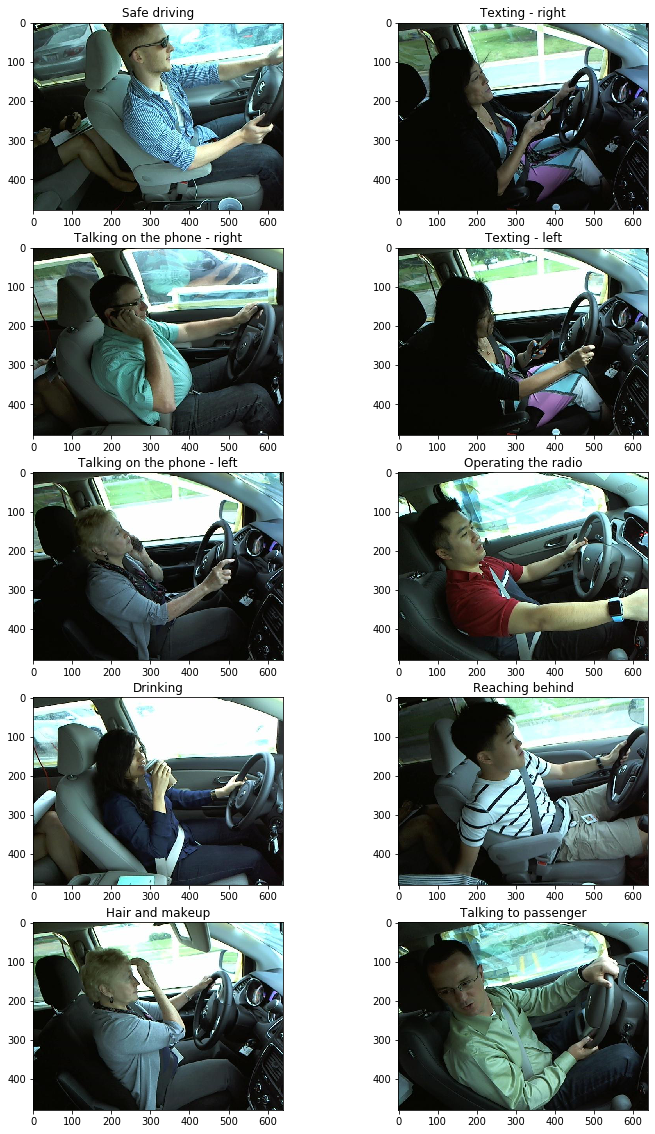

In [9]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = 'data/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [10]:
batch_size = 40
nb_epoch = 10

!rm -f saved_models/weights_best_vanilla.hdf5

models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

In [34]:

def create_model():
    # Optimised Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMG_W, IMG_H, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model 

In [35]:
model_v1 = create_model()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 64)       

In [13]:
# Training the Vanilla Model version 1
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)


Train on 17939 samples, validate on 4485 samples
Epoch 1/10


 7360/17939 [===========>..................] - ETA: 44:41 - loss: 3.2256 - accuracy: 0.150 - ETA: 27:12 - loss: 3.4680 - accuracy: 0.112 - ETA: 21:20 - loss: 3.4327 - accuracy: 0.116 - ETA: 18:21 - loss: 3.3329 - accuracy: 0.131 - ETA: 16:45 - loss: 3.4428 - accuracy: 0.115 - ETA: 15:27 - loss: 3.3302 - accuracy: 0.120 - ETA: 14:26 - loss: 3.2918 - accuracy: 0.121 - ETA: 13:39 - loss: 3.2503 - accuracy: 0.115 - ETA: 13:06 - loss: 3.2309 - accuracy: 0.116 - ETA: 12:56 - loss: 3.1883 - accuracy: 0.115 - ETA: 12:46 - loss: 3.1932 - accuracy: 0.115 - ETA: 12:30 - loss: 3.1692 - accuracy: 0.112 - ETA: 12:14 - loss: 3.1408 - accuracy: 0.125 - ETA: 12:12 - loss: 3.1041 - accuracy: 0.132 - ETA: 12:00 - loss: 3.0737 - accuracy: 0.131 - ETA: 11:49 - loss: 3.0925 - accuracy: 0.126 - ETA: 11:39 - loss: 3.0852 - accuracy: 0.123 - ETA: 11:35 - loss: 3.0856 - accuracy: 0.123 - ETA: 11:26 - loss: 3.0897 - accuracy: 0.125 - ETA: 11:20 - loss: 3.0741 - accuracy: 0.126 - ETA: 11:16 - loss: 3.0553 - accur

14800/17939 [=======================>......] - ETA: 5:57 - loss: 1.9360 - accuracy: 0.37 - ETA: 5:56 - loss: 1.9296 - accuracy: 0.38 - ETA: 5:54 - loss: 1.9264 - accuracy: 0.38 - ETA: 5:53 - loss: 1.9224 - accuracy: 0.38 - ETA: 5:51 - loss: 1.9195 - accuracy: 0.38 - ETA: 5:50 - loss: 1.9155 - accuracy: 0.38 - ETA: 5:48 - loss: 1.9117 - accuracy: 0.38 - ETA: 5:47 - loss: 1.9065 - accuracy: 0.38 - ETA: 5:46 - loss: 1.9018 - accuracy: 0.38 - ETA: 5:44 - loss: 1.8981 - accuracy: 0.38 - ETA: 5:43 - loss: 1.8938 - accuracy: 0.39 - ETA: 5:41 - loss: 1.8920 - accuracy: 0.39 - ETA: 5:40 - loss: 1.8878 - accuracy: 0.39 - ETA: 5:38 - loss: 1.8841 - accuracy: 0.39 - ETA: 5:37 - loss: 1.8802 - accuracy: 0.39 - ETA: 5:35 - loss: 1.8773 - accuracy: 0.39 - ETA: 5:34 - loss: 1.8732 - accuracy: 0.39 - ETA: 5:33 - loss: 1.8686 - accuracy: 0.39 - ETA: 5:31 - loss: 1.8638 - accuracy: 0.39 - ETA: 5:30 - loss: 1.8610 - accuracy: 0.39 - ETA: 5:28 - loss: 1.8573 - accuracy: 0.40 - ETA: 5:27 - loss: 1.8541 - ac

17939/17939 [==============================] - ETA: 1:42 - loss: 1.3933 - accuracy: 0.54 - ETA: 1:41 - loss: 1.3914 - accuracy: 0.54 - ETA: 1:39 - loss: 1.3895 - accuracy: 0.54 - ETA: 1:38 - loss: 1.3873 - accuracy: 0.54 - ETA: 1:37 - loss: 1.3849 - accuracy: 0.54 - ETA: 1:35 - loss: 1.3828 - accuracy: 0.55 - ETA: 1:34 - loss: 1.3799 - accuracy: 0.55 - ETA: 1:33 - loss: 1.3780 - accuracy: 0.55 - ETA: 1:31 - loss: 1.3760 - accuracy: 0.55 - ETA: 1:30 - loss: 1.3742 - accuracy: 0.55 - ETA: 1:29 - loss: 1.3727 - accuracy: 0.55 - ETA: 1:27 - loss: 1.3700 - accuracy: 0.55 - ETA: 1:26 - loss: 1.3673 - accuracy: 0.55 - ETA: 1:25 - loss: 1.3659 - accuracy: 0.55 - ETA: 1:23 - loss: 1.3637 - accuracy: 0.55 - ETA: 1:22 - loss: 1.3613 - accuracy: 0.55 - ETA: 1:21 - loss: 1.3590 - accuracy: 0.55 - ETA: 1:19 - loss: 1.3582 - accuracy: 0.55 - ETA: 1:18 - loss: 1.3574 - accuracy: 0.55 - ETA: 1:17 - loss: 1.3555 - accuracy: 0.55 - ETA: 1:15 - loss: 1.3545 - accuracy: 0.55 - ETA: 1:14 - loss: 1.3522 - ac

 7400/17939 [===========>..................] - ETA: 10:52 - loss: 0.5942 - accuracy: 0.800 - ETA: 10:32 - loss: 0.6831 - accuracy: 0.800 - ETA: 10:19 - loss: 0.6375 - accuracy: 0.816 - ETA: 10:16 - loss: 0.5172 - accuracy: 0.843 - ETA: 10:05 - loss: 0.5059 - accuracy: 0.835 - ETA: 9:46 - loss: 0.4743 - accuracy: 0.841 - ETA: 9:42 - loss: 0.5310 - accuracy: 0.81 - ETA: 9:44 - loss: 0.5223 - accuracy: 0.81 - ETA: 9:37 - loss: 0.5299 - accuracy: 0.82 - ETA: 9:34 - loss: 0.5174 - accuracy: 0.82 - ETA: 9:31 - loss: 0.5133 - accuracy: 0.82 - ETA: 9:38 - loss: 0.4997 - accuracy: 0.83 - ETA: 9:41 - loss: 0.4911 - accuracy: 0.83 - ETA: 9:37 - loss: 0.4830 - accuracy: 0.83 - ETA: 9:40 - loss: 0.4727 - accuracy: 0.83 - ETA: 9:37 - loss: 0.4647 - accuracy: 0.83 - ETA: 9:40 - loss: 0.4675 - accuracy: 0.83 - ETA: 9:37 - loss: 0.4669 - accuracy: 0.83 - ETA: 9:33 - loss: 0.4704 - accuracy: 0.83 - ETA: 9:32 - loss: 0.4653 - accuracy: 0.83 - ETA: 9:30 - loss: 0.4746 - accuracy: 0.83 - ETA: 9:27 - loss: 

14840/17939 [=======================>......] - ETA: 5:44 - loss: 0.4261 - accuracy: 0.86 - ETA: 5:43 - loss: 0.4255 - accuracy: 0.86 - ETA: 5:41 - loss: 0.4259 - accuracy: 0.86 - ETA: 5:40 - loss: 0.4272 - accuracy: 0.86 - ETA: 5:39 - loss: 0.4270 - accuracy: 0.86 - ETA: 5:38 - loss: 0.4256 - accuracy: 0.86 - ETA: 5:36 - loss: 0.4249 - accuracy: 0.86 - ETA: 5:35 - loss: 0.4237 - accuracy: 0.86 - ETA: 5:33 - loss: 0.4229 - accuracy: 0.86 - ETA: 5:32 - loss: 0.4220 - accuracy: 0.86 - ETA: 5:31 - loss: 0.4209 - accuracy: 0.86 - ETA: 5:29 - loss: 0.4205 - accuracy: 0.86 - ETA: 5:28 - loss: 0.4190 - accuracy: 0.86 - ETA: 5:27 - loss: 0.4183 - accuracy: 0.86 - ETA: 5:25 - loss: 0.4178 - accuracy: 0.86 - ETA: 5:24 - loss: 0.4177 - accuracy: 0.86 - ETA: 5:23 - loss: 0.4176 - accuracy: 0.86 - ETA: 5:22 - loss: 0.4170 - accuracy: 0.86 - ETA: 5:20 - loss: 0.4159 - accuracy: 0.86 - ETA: 5:19 - loss: 0.4148 - accuracy: 0.86 - ETA: 5:18 - loss: 0.4143 - accuracy: 0.86 - ETA: 5:16 - loss: 0.4131 - ac

17939/17939 [==============================] - ETA: 1:39 - loss: 0.3692 - accuracy: 0.88 - ETA: 1:38 - loss: 0.3686 - accuracy: 0.88 - ETA: 1:36 - loss: 0.3679 - accuracy: 0.88 - ETA: 1:35 - loss: 0.3675 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3674 - accuracy: 0.88 - ETA: 1:33 - loss: 0.3674 - accuracy: 0.88 - ETA: 1:31 - loss: 0.3672 - accuracy: 0.88 - ETA: 1:30 - loss: 0.3669 - accuracy: 0.88 - ETA: 1:29 - loss: 0.3666 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3662 - accuracy: 0.88 - ETA: 1:26 - loss: 0.3662 - accuracy: 0.88 - ETA: 1:25 - loss: 0.3663 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3671 - accuracy: 0.88 - ETA: 1:22 - loss: 0.3677 - accuracy: 0.88 - ETA: 1:21 - loss: 0.3673 - accuracy: 0.88 - ETA: 1:20 - loss: 0.3667 - accuracy: 0.88 - ETA: 1:18 - loss: 0.3666 - accuracy: 0.88 - ETA: 1:17 - loss: 0.3662 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3659 - accuracy: 0.88 - ETA: 1:14 - loss: 0.3658 - accuracy: 0.88 - ETA: 1:13 - loss: 0.3657 - accuracy: 0.88 - ETA: 1:12 - loss: 0.3656 - ac

 7440/17939 [===========>..................] - ETA: 10:23 - loss: 0.0919 - accuracy: 0.975 - ETA: 9:44 - loss: 0.1180 - accuracy: 0.962 - ETA: 9:26 - loss: 0.2541 - accuracy: 0.91 - ETA: 9:25 - loss: 0.2971 - accuracy: 0.91 - ETA: 9:17 - loss: 0.2473 - accuracy: 0.93 - ETA: 9:24 - loss: 0.2403 - accuracy: 0.92 - ETA: 9:24 - loss: 0.2829 - accuracy: 0.91 - ETA: 9:27 - loss: 0.2599 - accuracy: 0.92 - ETA: 9:21 - loss: 0.2834 - accuracy: 0.91 - ETA: 9:16 - loss: 0.2693 - accuracy: 0.92 - ETA: 9:15 - loss: 0.2584 - accuracy: 0.92 - ETA: 9:16 - loss: 0.2440 - accuracy: 0.92 - ETA: 9:19 - loss: 0.2718 - accuracy: 0.92 - ETA: 9:21 - loss: 0.2706 - accuracy: 0.92 - ETA: 9:17 - loss: 0.2741 - accuracy: 0.92 - ETA: 9:20 - loss: 0.2603 - accuracy: 0.92 - ETA: 9:19 - loss: 0.2528 - accuracy: 0.92 - ETA: 9:19 - loss: 0.2539 - accuracy: 0.92 - ETA: 9:18 - loss: 0.2530 - accuracy: 0.92 - ETA: 9:20 - loss: 0.2494 - accuracy: 0.92 - ETA: 9:19 - loss: 0.2546 - accuracy: 0.92 - ETA: 9:18 - loss: 0.2518 -

14880/17939 [=======================>......] - ETA: 5:45 - loss: 0.2287 - accuracy: 0.92 - ETA: 5:43 - loss: 0.2292 - accuracy: 0.92 - ETA: 5:42 - loss: 0.2293 - accuracy: 0.92 - ETA: 5:40 - loss: 0.2288 - accuracy: 0.92 - ETA: 5:39 - loss: 0.2285 - accuracy: 0.92 - ETA: 5:38 - loss: 0.2282 - accuracy: 0.92 - ETA: 5:36 - loss: 0.2292 - accuracy: 0.92 - ETA: 5:35 - loss: 0.2291 - accuracy: 0.92 - ETA: 5:34 - loss: 0.2281 - accuracy: 0.92 - ETA: 5:32 - loss: 0.2274 - accuracy: 0.92 - ETA: 5:31 - loss: 0.2271 - accuracy: 0.92 - ETA: 5:30 - loss: 0.2272 - accuracy: 0.92 - ETA: 5:28 - loss: 0.2266 - accuracy: 0.92 - ETA: 5:27 - loss: 0.2264 - accuracy: 0.92 - ETA: 5:26 - loss: 0.2267 - accuracy: 0.92 - ETA: 5:24 - loss: 0.2262 - accuracy: 0.92 - ETA: 5:23 - loss: 0.2257 - accuracy: 0.92 - ETA: 5:22 - loss: 0.2259 - accuracy: 0.92 - ETA: 5:20 - loss: 0.2255 - accuracy: 0.92 - ETA: 5:19 - loss: 0.2261 - accuracy: 0.92 - ETA: 5:18 - loss: 0.2261 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2252 - ac

17939/17939 [==============================] - ETA: 1:39 - loss: 0.2179 - accuracy: 0.93 - ETA: 1:37 - loss: 0.2179 - accuracy: 0.93 - ETA: 1:36 - loss: 0.2179 - accuracy: 0.93 - ETA: 1:35 - loss: 0.2187 - accuracy: 0.93 - ETA: 1:33 - loss: 0.2184 - accuracy: 0.93 - ETA: 1:32 - loss: 0.2183 - accuracy: 0.93 - ETA: 1:31 - loss: 0.2185 - accuracy: 0.93 - ETA: 1:30 - loss: 0.2185 - accuracy: 0.93 - ETA: 1:28 - loss: 0.2184 - accuracy: 0.93 - ETA: 1:27 - loss: 0.2188 - accuracy: 0.93 - ETA: 1:26 - loss: 0.2192 - accuracy: 0.93 - ETA: 1:24 - loss: 0.2189 - accuracy: 0.93 - ETA: 1:23 - loss: 0.2196 - accuracy: 0.93 - ETA: 1:22 - loss: 0.2203 - accuracy: 0.93 - ETA: 1:20 - loss: 0.2201 - accuracy: 0.93 - ETA: 1:19 - loss: 0.2196 - accuracy: 0.93 - ETA: 1:18 - loss: 0.2197 - accuracy: 0.93 - ETA: 1:16 - loss: 0.2199 - accuracy: 0.93 - ETA: 1:15 - loss: 0.2196 - accuracy: 0.93 - ETA: 1:14 - loss: 0.2193 - accuracy: 0.93 - ETA: 1:12 - loss: 0.2192 - accuracy: 0.93 - ETA: 1:11 - loss: 0.2195 - ac

 7440/17939 [===========>..................] - ETA: 9:19 - loss: 0.1083 - accuracy: 0.97 - ETA: 9:28 - loss: 0.1895 - accuracy: 0.93 - ETA: 9:30 - loss: 0.1958 - accuracy: 0.94 - ETA: 9:20 - loss: 0.1718 - accuracy: 0.93 - ETA: 9:20 - loss: 0.1655 - accuracy: 0.93 - ETA: 9:17 - loss: 0.1519 - accuracy: 0.93 - ETA: 9:21 - loss: 0.1520 - accuracy: 0.93 - ETA: 9:21 - loss: 0.1459 - accuracy: 0.93 - ETA: 9:23 - loss: 0.1569 - accuracy: 0.93 - ETA: 9:22 - loss: 0.1558 - accuracy: 0.93 - ETA: 9:19 - loss: 0.1529 - accuracy: 0.93 - ETA: 9:13 - loss: 0.1452 - accuracy: 0.93 - ETA: 9:09 - loss: 0.1378 - accuracy: 0.94 - ETA: 9:09 - loss: 0.1401 - accuracy: 0.94 - ETA: 9:10 - loss: 0.1509 - accuracy: 0.94 - ETA: 9:11 - loss: 0.1645 - accuracy: 0.93 - ETA: 9:09 - loss: 0.1750 - accuracy: 0.93 - ETA: 9:06 - loss: 0.1667 - accuracy: 0.93 - ETA: 9:02 - loss: 0.1593 - accuracy: 0.94 - ETA: 9:00 - loss: 0.1582 - accuracy: 0.94 - ETA: 9:01 - loss: 0.1536 - accuracy: 0.94 - ETA: 9:01 - loss: 0.1608 - ac

14880/17939 [=======================>......] - ETA: 5:39 - loss: 0.1680 - accuracy: 0.94 - ETA: 5:38 - loss: 0.1683 - accuracy: 0.94 - ETA: 5:36 - loss: 0.1695 - accuracy: 0.94 - ETA: 5:35 - loss: 0.1689 - accuracy: 0.94 - ETA: 5:34 - loss: 0.1690 - accuracy: 0.94 - ETA: 5:32 - loss: 0.1688 - accuracy: 0.94 - ETA: 5:31 - loss: 0.1680 - accuracy: 0.94 - ETA: 5:30 - loss: 0.1687 - accuracy: 0.94 - ETA: 5:28 - loss: 0.1689 - accuracy: 0.94 - ETA: 5:27 - loss: 0.1689 - accuracy: 0.94 - ETA: 5:25 - loss: 0.1688 - accuracy: 0.94 - ETA: 5:24 - loss: 0.1688 - accuracy: 0.94 - ETA: 5:23 - loss: 0.1687 - accuracy: 0.94 - ETA: 5:22 - loss: 0.1697 - accuracy: 0.94 - ETA: 5:20 - loss: 0.1699 - accuracy: 0.94 - ETA: 5:19 - loss: 0.1699 - accuracy: 0.94 - ETA: 5:18 - loss: 0.1700 - accuracy: 0.94 - ETA: 5:16 - loss: 0.1696 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1691 - accuracy: 0.94 - ETA: 5:13 - loss: 0.1695 - accuracy: 0.94 - ETA: 5:12 - loss: 0.1694 - accuracy: 0.94 - ETA: 5:11 - loss: 0.1688 - ac

17939/17939 [==============================] - ETA: 1:38 - loss: 0.1623 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1620 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1620 - accuracy: 0.95 - ETA: 1:34 - loss: 0.1618 - accuracy: 0.95 - ETA: 1:33 - loss: 0.1615 - accuracy: 0.95 - ETA: 1:32 - loss: 0.1611 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1618 - accuracy: 0.95 - ETA: 1:29 - loss: 0.1617 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1614 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1611 - accuracy: 0.95 - ETA: 1:25 - loss: 0.1611 - accuracy: 0.95 - ETA: 1:24 - loss: 0.1607 - accuracy: 0.95 - ETA: 1:23 - loss: 0.1604 - accuracy: 0.95 - ETA: 1:21 - loss: 0.1605 - accuracy: 0.95 - ETA: 1:20 - loss: 0.1604 - accuracy: 0.95 - ETA: 1:19 - loss: 0.1602 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1599 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1605 - accuracy: 0.95 - ETA: 1:15 - loss: 0.1608 - accuracy: 0.95 - ETA: 1:13 - loss: 0.1611 - accuracy: 0.95 - ETA: 1:12 - loss: 0.1609 - accuracy: 0.95 - ETA: 1:11 - loss: 0.1612 - ac

 7440/17939 [===========>..................] - ETA: 9:28 - loss: 0.0254 - accuracy: 1.00 - ETA: 8:59 - loss: 0.0354 - accuracy: 0.98 - ETA: 9:24 - loss: 0.0327 - accuracy: 0.99 - ETA: 9:39 - loss: 0.0474 - accuracy: 0.98 - ETA: 9:41 - loss: 0.0448 - accuracy: 0.99 - ETA: 9:46 - loss: 0.0611 - accuracy: 0.98 - ETA: 9:48 - loss: 0.0761 - accuracy: 0.97 - ETA: 9:43 - loss: 0.0681 - accuracy: 0.98 - ETA: 9:45 - loss: 0.0749 - accuracy: 0.98 - ETA: 9:46 - loss: 0.0787 - accuracy: 0.98 - ETA: 9:46 - loss: 0.0745 - accuracy: 0.98 - ETA: 9:46 - loss: 0.0691 - accuracy: 0.98 - ETA: 9:44 - loss: 0.0698 - accuracy: 0.98 - ETA: 9:40 - loss: 0.0814 - accuracy: 0.98 - ETA: 9:37 - loss: 0.0799 - accuracy: 0.97 - ETA: 9:33 - loss: 0.0796 - accuracy: 0.97 - ETA: 9:32 - loss: 0.1028 - accuracy: 0.97 - ETA: 9:30 - loss: 0.1039 - accuracy: 0.97 - ETA: 9:28 - loss: 0.0995 - accuracy: 0.97 - ETA: 9:29 - loss: 0.0991 - accuracy: 0.97 - ETA: 9:26 - loss: 0.1050 - accuracy: 0.97 - ETA: 9:20 - loss: 0.1061 - ac

14880/17939 [=======================>......] - ETA: 5:42 - loss: 0.1364 - accuracy: 0.96 - ETA: 5:41 - loss: 0.1366 - accuracy: 0.96 - ETA: 5:39 - loss: 0.1372 - accuracy: 0.96 - ETA: 5:38 - loss: 0.1371 - accuracy: 0.96 - ETA: 5:37 - loss: 0.1380 - accuracy: 0.96 - ETA: 5:35 - loss: 0.1378 - accuracy: 0.96 - ETA: 5:34 - loss: 0.1381 - accuracy: 0.96 - ETA: 5:33 - loss: 0.1380 - accuracy: 0.96 - ETA: 5:31 - loss: 0.1376 - accuracy: 0.96 - ETA: 5:30 - loss: 0.1383 - accuracy: 0.96 - ETA: 5:29 - loss: 0.1379 - accuracy: 0.96 - ETA: 5:27 - loss: 0.1376 - accuracy: 0.96 - ETA: 5:26 - loss: 0.1373 - accuracy: 0.96 - ETA: 5:25 - loss: 0.1370 - accuracy: 0.96 - ETA: 5:23 - loss: 0.1370 - accuracy: 0.96 - ETA: 5:22 - loss: 0.1365 - accuracy: 0.96 - ETA: 5:21 - loss: 0.1366 - accuracy: 0.96 - ETA: 5:19 - loss: 0.1365 - accuracy: 0.96 - ETA: 5:18 - loss: 0.1362 - accuracy: 0.96 - ETA: 5:17 - loss: 0.1362 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1358 - accuracy: 0.96 - ETA: 5:14 - loss: 0.1365 - ac

17939/17939 [==============================] - ETA: 1:46 - loss: 0.1275 - accuracy: 0.96 - ETA: 1:44 - loss: 0.1279 - accuracy: 0.96 - ETA: 1:43 - loss: 0.1278 - accuracy: 0.96 - ETA: 1:41 - loss: 0.1278 - accuracy: 0.96 - ETA: 1:40 - loss: 0.1279 - accuracy: 0.96 - ETA: 1:39 - loss: 0.1278 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1281 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1285 - accuracy: 0.96 - ETA: 1:34 - loss: 0.1283 - accuracy: 0.96 - ETA: 1:33 - loss: 0.1281 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1279 - accuracy: 0.96 - ETA: 1:30 - loss: 0.1277 - accuracy: 0.96 - ETA: 1:29 - loss: 0.1274 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1282 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1290 - accuracy: 0.96 - ETA: 1:24 - loss: 0.1293 - accuracy: 0.96 - ETA: 1:23 - loss: 0.1293 - accuracy: 0.96 - ETA: 1:21 - loss: 0.1293 - accuracy: 0.96 - ETA: 1:20 - loss: 0.1293 - accuracy: 0.96 - ETA: 1:19 - loss: 0.1291 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1292 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1294 - ac

 7440/17939 [===========>..................] - ETA: 8:42 - loss: 0.1694 - accuracy: 0.95 - ETA: 9:20 - loss: 0.1777 - accuracy: 0.96 - ETA: 9:44 - loss: 0.1374 - accuracy: 0.96 - ETA: 9:39 - loss: 0.1268 - accuracy: 0.96 - ETA: 9:31 - loss: 0.1457 - accuracy: 0.95 - ETA: 9:27 - loss: 0.1500 - accuracy: 0.95 - ETA: 9:21 - loss: 0.1480 - accuracy: 0.95 - ETA: 9:21 - loss: 0.1357 - accuracy: 0.95 - ETA: 9:19 - loss: 0.1233 - accuracy: 0.95 - ETA: 9:21 - loss: 0.1115 - accuracy: 0.96 - ETA: 9:25 - loss: 0.1062 - accuracy: 0.96 - ETA: 9:26 - loss: 0.0981 - accuracy: 0.96 - ETA: 9:22 - loss: 0.1140 - accuracy: 0.96 - ETA: 9:23 - loss: 0.1123 - accuracy: 0.96 - ETA: 9:22 - loss: 0.1067 - accuracy: 0.96 - ETA: 9:20 - loss: 0.1028 - accuracy: 0.96 - ETA: 9:18 - loss: 0.1073 - accuracy: 0.96 - ETA: 9:14 - loss: 0.1126 - accuracy: 0.96 - ETA: 9:14 - loss: 0.1098 - accuracy: 0.96 - ETA: 9:09 - loss: 0.1179 - accuracy: 0.96 - ETA: 9:06 - loss: 0.1194 - accuracy: 0.96 - ETA: 9:04 - loss: 0.1156 - ac

14880/17939 [=======================>......] - ETA: 5:41 - loss: 0.1163 - accuracy: 0.96 - ETA: 5:40 - loss: 0.1160 - accuracy: 0.96 - ETA: 5:39 - loss: 0.1154 - accuracy: 0.96 - ETA: 5:37 - loss: 0.1149 - accuracy: 0.96 - ETA: 5:36 - loss: 0.1147 - accuracy: 0.96 - ETA: 5:34 - loss: 0.1144 - accuracy: 0.96 - ETA: 5:33 - loss: 0.1139 - accuracy: 0.96 - ETA: 5:32 - loss: 0.1136 - accuracy: 0.96 - ETA: 5:30 - loss: 0.1133 - accuracy: 0.96 - ETA: 5:29 - loss: 0.1129 - accuracy: 0.96 - ETA: 5:28 - loss: 0.1123 - accuracy: 0.96 - ETA: 5:26 - loss: 0.1120 - accuracy: 0.96 - ETA: 5:25 - loss: 0.1119 - accuracy: 0.96 - ETA: 5:24 - loss: 0.1126 - accuracy: 0.96 - ETA: 5:22 - loss: 0.1123 - accuracy: 0.96 - ETA: 5:21 - loss: 0.1119 - accuracy: 0.96 - ETA: 5:20 - loss: 0.1118 - accuracy: 0.96 - ETA: 5:18 - loss: 0.1115 - accuracy: 0.96 - ETA: 5:17 - loss: 0.1110 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1112 - accuracy: 0.96 - ETA: 5:14 - loss: 0.1109 - accuracy: 0.96 - ETA: 5:13 - loss: 0.1105 - ac

17939/17939 [==============================] - ETA: 1:38 - loss: 0.1076 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1078 - accuracy: 0.96 - ETA: 1:35 - loss: 0.1081 - accuracy: 0.96 - ETA: 1:34 - loss: 0.1079 - accuracy: 0.96 - ETA: 1:32 - loss: 0.1080 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1080 - accuracy: 0.96 - ETA: 1:30 - loss: 0.1079 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1083 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1080 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1081 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1079 - accuracy: 0.96 - ETA: 1:23 - loss: 0.1078 - accuracy: 0.96 - ETA: 1:22 - loss: 0.1076 - accuracy: 0.96 - ETA: 1:21 - loss: 0.1077 - accuracy: 0.96 - ETA: 1:19 - loss: 0.1077 - accuracy: 0.96 - ETA: 1:18 - loss: 0.1074 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1074 - accuracy: 0.96 - ETA: 1:15 - loss: 0.1071 - accuracy: 0.96 - ETA: 1:14 - loss: 0.1075 - accuracy: 0.96 - ETA: 1:13 - loss: 0.1075 - accuracy: 0.96 - ETA: 1:12 - loss: 0.1073 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1072 - ac

 7440/17939 [===========>..................] - ETA: 9:52 - loss: 0.2768 - accuracy: 0.95 - ETA: 9:19 - loss: 0.1676 - accuracy: 0.97 - ETA: 9:21 - loss: 0.1181 - accuracy: 0.98 - ETA: 9:29 - loss: 0.1383 - accuracy: 0.96 - ETA: 9:20 - loss: 0.1188 - accuracy: 0.97 - ETA: 9:10 - loss: 0.0999 - accuracy: 0.97 - ETA: 9:13 - loss: 0.1075 - accuracy: 0.97 - ETA: 9:24 - loss: 0.0950 - accuracy: 0.97 - ETA: 9:26 - loss: 0.1401 - accuracy: 0.97 - ETA: 9:24 - loss: 0.1350 - accuracy: 0.97 - ETA: 9:20 - loss: 0.1285 - accuracy: 0.97 - ETA: 9:14 - loss: 0.1216 - accuracy: 0.97 - ETA: 9:12 - loss: 0.1158 - accuracy: 0.97 - ETA: 9:11 - loss: 0.1080 - accuracy: 0.97 - ETA: 9:07 - loss: 0.1078 - accuracy: 0.97 - ETA: 9:06 - loss: 0.1017 - accuracy: 0.97 - ETA: 9:08 - loss: 0.0972 - accuracy: 0.98 - ETA: 9:06 - loss: 0.1017 - accuracy: 0.97 - ETA: 9:05 - loss: 0.1034 - accuracy: 0.97 - ETA: 9:05 - loss: 0.1136 - accuracy: 0.97 - ETA: 9:05 - loss: 0.1088 - accuracy: 0.97 - ETA: 9:05 - loss: 0.1056 - ac

14880/17939 [=======================>......] - ETA: 5:37 - loss: 0.1070 - accuracy: 0.97 - ETA: 5:36 - loss: 0.1072 - accuracy: 0.97 - ETA: 5:34 - loss: 0.1070 - accuracy: 0.97 - ETA: 5:33 - loss: 0.1065 - accuracy: 0.97 - ETA: 5:31 - loss: 0.1088 - accuracy: 0.97 - ETA: 5:30 - loss: 0.1104 - accuracy: 0.97 - ETA: 5:29 - loss: 0.1100 - accuracy: 0.97 - ETA: 5:28 - loss: 0.1094 - accuracy: 0.97 - ETA: 5:26 - loss: 0.1099 - accuracy: 0.97 - ETA: 5:25 - loss: 0.1096 - accuracy: 0.97 - ETA: 5:23 - loss: 0.1094 - accuracy: 0.97 - ETA: 5:22 - loss: 0.1091 - accuracy: 0.97 - ETA: 5:21 - loss: 0.1087 - accuracy: 0.97 - ETA: 5:19 - loss: 0.1112 - accuracy: 0.97 - ETA: 5:18 - loss: 0.1111 - accuracy: 0.97 - ETA: 5:17 - loss: 0.1117 - accuracy: 0.97 - ETA: 5:15 - loss: 0.1116 - accuracy: 0.97 - ETA: 5:14 - loss: 0.1115 - accuracy: 0.97 - ETA: 5:13 - loss: 0.1126 - accuracy: 0.97 - ETA: 5:11 - loss: 0.1124 - accuracy: 0.97 - ETA: 5:10 - loss: 0.1120 - accuracy: 0.97 - ETA: 5:09 - loss: 0.1118 - ac

17939/17939 [==============================] - ETA: 1:36 - loss: 0.1056 - accuracy: 0.96 - ETA: 1:35 - loss: 0.1055 - accuracy: 0.96 - ETA: 1:34 - loss: 0.1056 - accuracy: 0.96 - ETA: 1:32 - loss: 0.1056 - accuracy: 0.96 - ETA: 1:31 - loss: 0.1055 - accuracy: 0.96 - ETA: 1:30 - loss: 0.1053 - accuracy: 0.96 - ETA: 1:29 - loss: 0.1053 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1051 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1052 - accuracy: 0.96 - ETA: 1:23 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:22 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:21 - loss: 0.1054 - accuracy: 0.96 - ETA: 1:20 - loss: 0.1066 - accuracy: 0.96 - ETA: 1:18 - loss: 0.1064 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1061 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1059 - accuracy: 0.96 - ETA: 1:15 - loss: 0.1059 - accuracy: 0.96 - ETA: 1:13 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:12 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:11 - loss: 0.1055 - accuracy: 0.96 - ETA: 1:09 - loss: 0.1054 - ac

 7440/17939 [===========>..................] - ETA: 9:34 - loss: 0.0136 - accuracy: 1.00 - ETA: 9:45 - loss: 0.0182 - accuracy: 1.00 - ETA: 9:42 - loss: 0.0164 - accuracy: 1.00 - ETA: 9:28 - loss: 0.0209 - accuracy: 0.99 - ETA: 9:24 - loss: 0.0180 - accuracy: 0.99 - ETA: 9:18 - loss: 0.0580 - accuracy: 0.98 - ETA: 9:11 - loss: 0.0531 - accuracy: 0.98 - ETA: 9:14 - loss: 0.0490 - accuracy: 0.98 - ETA: 9:21 - loss: 0.0532 - accuracy: 0.98 - ETA: 9:14 - loss: 0.0623 - accuracy: 0.97 - ETA: 9:13 - loss: 0.0753 - accuracy: 0.97 - ETA: 9:12 - loss: 0.0876 - accuracy: 0.97 - ETA: 9:11 - loss: 0.0828 - accuracy: 0.97 - ETA: 9:08 - loss: 0.0922 - accuracy: 0.97 - ETA: 9:08 - loss: 0.0866 - accuracy: 0.97 - ETA: 9:10 - loss: 0.0823 - accuracy: 0.97 - ETA: 9:07 - loss: 0.0822 - accuracy: 0.97 - ETA: 9:07 - loss: 0.0786 - accuracy: 0.98 - ETA: 9:05 - loss: 0.0750 - accuracy: 0.98 - ETA: 9:05 - loss: 0.0714 - accuracy: 0.98 - ETA: 9:03 - loss: 0.0683 - accuracy: 0.98 - ETA: 9:03 - loss: 0.0693 - ac

14880/17939 [=======================>......] - ETA: 5:39 - loss: 0.0918 - accuracy: 0.97 - ETA: 5:38 - loss: 0.0913 - accuracy: 0.97 - ETA: 5:36 - loss: 0.0909 - accuracy: 0.97 - ETA: 5:35 - loss: 0.0904 - accuracy: 0.97 - ETA: 5:34 - loss: 0.0900 - accuracy: 0.97 - ETA: 5:32 - loss: 0.0899 - accuracy: 0.97 - ETA: 5:31 - loss: 0.0898 - accuracy: 0.97 - ETA: 5:30 - loss: 0.0897 - accuracy: 0.97 - ETA: 5:28 - loss: 0.0903 - accuracy: 0.97 - ETA: 5:27 - loss: 0.0899 - accuracy: 0.97 - ETA: 5:26 - loss: 0.0896 - accuracy: 0.97 - ETA: 5:24 - loss: 0.0895 - accuracy: 0.97 - ETA: 5:23 - loss: 0.0899 - accuracy: 0.97 - ETA: 5:22 - loss: 0.0895 - accuracy: 0.97 - ETA: 5:21 - loss: 0.0900 - accuracy: 0.97 - ETA: 5:19 - loss: 0.0902 - accuracy: 0.97 - ETA: 5:18 - loss: 0.0908 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0906 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0905 - accuracy: 0.97 - ETA: 5:14 - loss: 0.0903 - accuracy: 0.97 - ETA: 5:13 - loss: 0.0906 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0902 - ac

17939/17939 [==============================] - ETA: 1:37 - loss: 0.0919 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0918 - accuracy: 0.97 - ETA: 1:34 - loss: 0.0917 - accuracy: 0.97 - ETA: 1:33 - loss: 0.0916 - accuracy: 0.97 - ETA: 1:32 - loss: 0.0914 - accuracy: 0.97 - ETA: 1:30 - loss: 0.0912 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0913 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0913 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0915 - accuracy: 0.97 - ETA: 1:25 - loss: 0.0914 - accuracy: 0.97 - ETA: 1:24 - loss: 0.0912 - accuracy: 0.97 - ETA: 1:23 - loss: 0.0913 - accuracy: 0.97 - ETA: 1:21 - loss: 0.0916 - accuracy: 0.97 - ETA: 1:20 - loss: 0.0916 - accuracy: 0.97 - ETA: 1:19 - loss: 0.0913 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0912 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0909 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0908 - accuracy: 0.97 - ETA: 1:14 - loss: 0.0908 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0906 - accuracy: 0.97 - ETA: 1:11 - loss: 0.0904 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0902 - ac

 7440/17939 [===========>..................] - ETA: 9:37 - loss: 0.0772 - accuracy: 0.97 - ETA: 9:11 - loss: 0.0601 - accuracy: 0.97 - ETA: 9:15 - loss: 0.0485 - accuracy: 0.98 - ETA: 9:35 - loss: 0.0628 - accuracy: 0.97 - ETA: 9:48 - loss: 0.0511 - accuracy: 0.98 - ETA: 9:47 - loss: 0.0428 - accuracy: 0.98 - ETA: 9:47 - loss: 0.0621 - accuracy: 0.97 - ETA: 9:38 - loss: 0.0558 - accuracy: 0.98 - ETA: 9:39 - loss: 0.0990 - accuracy: 0.98 - ETA: 9:34 - loss: 0.0899 - accuracy: 0.98 - ETA: 9:36 - loss: 0.0832 - accuracy: 0.98 - ETA: 9:34 - loss: 0.0767 - accuracy: 0.98 - ETA: 9:30 - loss: 0.0713 - accuracy: 0.98 - ETA: 9:32 - loss: 0.0665 - accuracy: 0.98 - ETA: 9:27 - loss: 0.0625 - accuracy: 0.98 - ETA: 9:22 - loss: 0.0587 - accuracy: 0.98 - ETA: 9:19 - loss: 0.0596 - accuracy: 0.98 - ETA: 9:19 - loss: 0.0580 - accuracy: 0.98 - ETA: 9:16 - loss: 0.0551 - accuracy: 0.98 - ETA: 9:18 - loss: 0.0570 - accuracy: 0.98 - ETA: 9:17 - loss: 0.0552 - accuracy: 0.98 - ETA: 9:13 - loss: 0.0617 - ac

14880/17939 [=======================>......] - ETA: 5:43 - loss: 0.0821 - accuracy: 0.97 - ETA: 5:41 - loss: 0.0818 - accuracy: 0.97 - ETA: 5:40 - loss: 0.0814 - accuracy: 0.97 - ETA: 5:39 - loss: 0.0810 - accuracy: 0.97 - ETA: 5:37 - loss: 0.0813 - accuracy: 0.97 - ETA: 5:36 - loss: 0.0809 - accuracy: 0.97 - ETA: 5:35 - loss: 0.0808 - accuracy: 0.97 - ETA: 5:33 - loss: 0.0805 - accuracy: 0.97 - ETA: 5:32 - loss: 0.0801 - accuracy: 0.97 - ETA: 5:31 - loss: 0.0805 - accuracy: 0.97 - ETA: 5:30 - loss: 0.0804 - accuracy: 0.97 - ETA: 5:28 - loss: 0.0805 - accuracy: 0.97 - ETA: 5:27 - loss: 0.0806 - accuracy: 0.97 - ETA: 5:26 - loss: 0.0803 - accuracy: 0.97 - ETA: 5:24 - loss: 0.0799 - accuracy: 0.97 - ETA: 5:23 - loss: 0.0796 - accuracy: 0.97 - ETA: 5:22 - loss: 0.0794 - accuracy: 0.97 - ETA: 5:20 - loss: 0.0791 - accuracy: 0.97 - ETA: 5:19 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:18 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0784 - accuracy: 0.97 - ETA: 5:15 - loss: 0.0789 - ac

17939/17939 [==============================] - ETA: 1:40 - loss: 0.0816 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0821 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0819 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0820 - accuracy: 0.97 - ETA: 1:35 - loss: 0.0822 - accuracy: 0.97 - ETA: 1:34 - loss: 0.0820 - accuracy: 0.97 - ETA: 1:32 - loss: 0.0821 - accuracy: 0.97 - ETA: 1:31 - loss: 0.0819 - accuracy: 0.97 - ETA: 1:30 - loss: 0.0822 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0822 - accuracy: 0.97 - ETA: 1:27 - loss: 0.0820 - accuracy: 0.97 - ETA: 1:26 - loss: 0.0824 - accuracy: 0.97 - ETA: 1:24 - loss: 0.0823 - accuracy: 0.97 - ETA: 1:23 - loss: 0.0822 - accuracy: 0.97 - ETA: 1:21 - loss: 0.0824 - accuracy: 0.97 - ETA: 1:20 - loss: 0.0822 - accuracy: 0.97 - ETA: 1:19 - loss: 0.0820 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0821 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0823 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0829 - accuracy: 0.97 - ETA: 1:13 - loss: 0.0831 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0833 - ac

In [21]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')


In [15]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

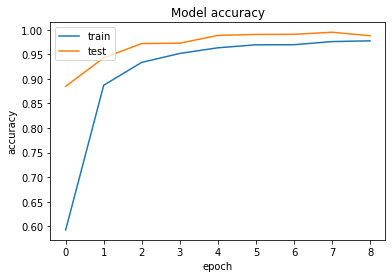

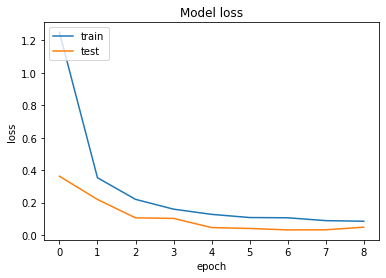

In [22]:
plot_train_history(history_v1)

In [23]:
score = model_v1.evaluate(x_test, y_test, verbose=1)


4485/4485 [==============================] - ETA: 1: - ETA: 59s - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 21 - ETA

In [24]:
print('Score: ', score)

Score:  [0.03139561184650415, 0.9908584356307983]


In [26]:
y_pred = model_v1.predict(x_test, batch_size=batch_size, verbose=1)
score = log_loss(y_test, y_pred)


4485/4485 [==============================] - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 9 - ETA: 

In [29]:
print('Score log loss:', score)

Score log loss: 0.031395607781842444


In [43]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(IMG_W,IMG_H))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,IMG_W,IMG_H,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()
    
    return y_prediction


1/1 [==============================] - 1s 902ms/step
Y prediction: [[8.3877522e-10 2.5749737e-03 3.9625490e-09 3.5657138e-02 1.8062862e-02
  3.5511662e-09 1.8959869e-02 9.1165036e-01 4.6293999e-04 1.2631929e-02]]
Predicted: Reaching behind


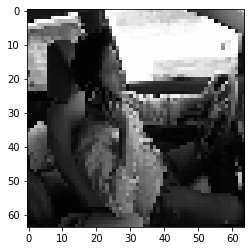

Y prediction: None
Predicted: Safe driving


In [39]:
y_prediction = plot_test_class(model_v1, test_files, 20)
print('Y prediction: {}'.format(y_prediction))
print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    

1/1 [==============================] - 0s 69ms/step
Y prediction: [[1.21635035e-09 3.60609876e-04 1.79888158e-08 5.64814638e-03
  1.16122566e-01 4.80679441e-10 2.80254543e-01 5.86428106e-01
  4.31422923e-05 1.11428499e-02]]
Predicted: Reaching behind


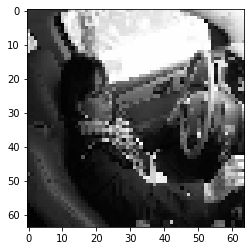

Y prediction: [[1.21635035e-09 3.60609876e-04 1.79888158e-08 5.64814638e-03
  1.16122566e-01 4.80679441e-10 2.80254543e-01 5.86428106e-01
  4.31422923e-05 1.11428499e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 63ms/step
Y prediction: [[8.5775056e-08 8.3436564e-05 5.5997287e-08 1.7297974e-02 4.6739087e-01
  4.3530224e-09 4.0647492e-01 1.0314485e-01 4.9642305e-05 5.5581927e-03]]
Predicted: Talking on the phone - left


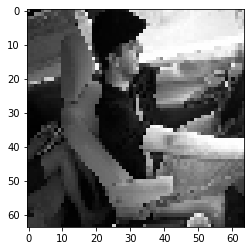

Y prediction: [[8.5775056e-08 8.3436564e-05 5.5997287e-08 1.7297974e-02 4.6739087e-01
  4.3530224e-09 4.0647492e-01 1.0314485e-01 4.9642305e-05 5.5581927e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 37ms/step
Y prediction: [[1.6981238e-08 4.6484137e-04 2.2113467e-07 2.1186981e-03 2.3095468e-01
  1.1131959e-08 6.5073036e-02 6.9820201e-01 8.0238184e-05 3.1062078e-03]]
Predicted: Reaching behind


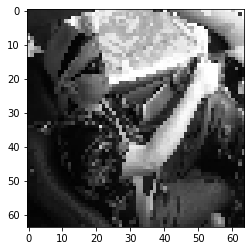

Y prediction: [[1.6981238e-08 4.6484137e-04 2.2113467e-07 2.1186981e-03 2.3095468e-01
  1.1131959e-08 6.5073036e-02 6.9820201e-01 8.0238184e-05 3.1062078e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 129ms/step
Y prediction: [[3.9196829e-10 3.4577929e-04 1.4763366e-08 1.0665206e-01 6.8289840e-01
  1.8407155e-08 2.3805179e-02 1.8589349e-01 5.8624235e-05 3.4648998e-04]]
Predicted: Talking on the phone - left


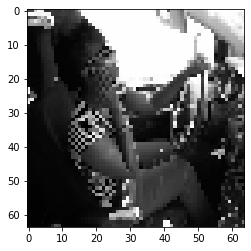

Y prediction: [[3.9196829e-10 3.4577929e-04 1.4763366e-08 1.0665206e-01 6.8289840e-01
  1.8407155e-08 2.3805179e-02 1.8589349e-01 5.8624235e-05 3.4648998e-04]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 318ms/step
Y prediction: [[1.9317307e-07 3.7577654e-05 4.3660733e-09 3.5383083e-02 8.3874649e-01
  6.5695938e-10 1.1037892e-01 1.3085333e-02 4.6757228e-05 2.3216370e-03]]
Predicted: Talking on the phone - left


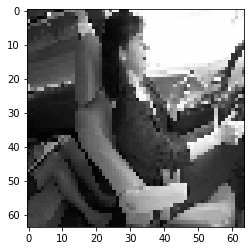

Y prediction: [[1.9317307e-07 3.7577654e-05 4.3660733e-09 3.5383083e-02 8.3874649e-01
  6.5695938e-10 1.1037892e-01 1.3085333e-02 4.6757228e-05 2.3216370e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 144ms/step
Y prediction: [[3.5424153e-09 9.6283067e-04 2.6169065e-08 6.2382445e-02 5.3400964e-02
  8.9486540e-10 2.2746265e-01 5.6854683e-01 7.4046053e-04 8.6503826e-02]]
Predicted: Reaching behind


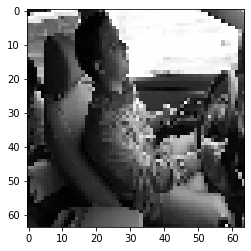

Y prediction: [[3.5424153e-09 9.6283067e-04 2.6169065e-08 6.2382445e-02 5.3400964e-02
  8.9486540e-10 2.2746265e-01 5.6854683e-01 7.4046053e-04 8.6503826e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 209ms/step
Y prediction: [[9.8898070e-11 5.6055906e-05 4.7735971e-10 1.4607321e-03 8.6320400e-02
  1.0210707e-11 5.3452078e-02 8.5721916e-01 2.8916993e-06 1.4887174e-03]]
Predicted: Reaching behind


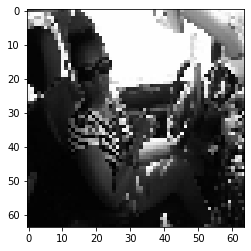

Y prediction: [[9.8898070e-11 5.6055906e-05 4.7735971e-10 1.4607321e-03 8.6320400e-02
  1.0210707e-11 5.3452078e-02 8.5721916e-01 2.8916993e-06 1.4887174e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 165ms/step
Y prediction: [[1.1334298e-09 4.1643865e-04 5.7794414e-09 7.1709901e-01 6.4422719e-02
  6.9820629e-09 2.4710629e-02 1.8747275e-01 2.5059210e-04 5.6278445e-03]]
Predicted: Texting - left


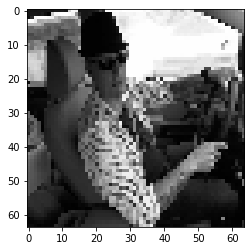

Y prediction: [[1.1334298e-09 4.1643865e-04 5.7794414e-09 7.1709901e-01 6.4422719e-02
  6.9820629e-09 2.4710629e-02 1.8747275e-01 2.5059210e-04 5.6278445e-03]]
Predicted: Texting - left
1/1 [==============================] - 0s 46ms/step
Y prediction: [[8.7802498e-08 1.2434662e-04 1.3297783e-07 7.2004995e-03 3.6962610e-01
  2.2891582e-09 2.7083072e-01 3.4028050e-01 5.6493624e-05 1.1881181e-02]]
Predicted: Talking on the phone - left


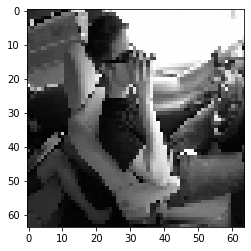

Y prediction: [[8.7802498e-08 1.2434662e-04 1.3297783e-07 7.2004995e-03 3.6962610e-01
  2.2891582e-09 2.7083072e-01 3.4028050e-01 5.6493624e-05 1.1881181e-02]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 291ms/step
Y prediction: [[4.6469557e-09 5.8603757e-05 3.2153807e-08 1.1781667e-02 1.0522518e-01
  6.3379479e-09 1.2792574e-02 8.6800522e-01 2.1283493e-05 2.1155479e-03]]
Predicted: Reaching behind


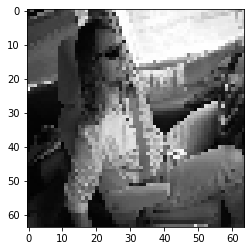

Y prediction: [[4.6469557e-09 5.8603757e-05 3.2153807e-08 1.1781667e-02 1.0522518e-01
  6.3379479e-09 1.2792574e-02 8.6800522e-01 2.1283493e-05 2.1155479e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 194ms/step
Y prediction: [[8.9999750e-09 1.4008807e-03 7.8357667e-09 7.6271459e-03 3.2882705e-02
  3.0783007e-10 6.1024094e-01 3.0832154e-01 1.3883793e-04 3.9387923e-02]]
Predicted: Drinking


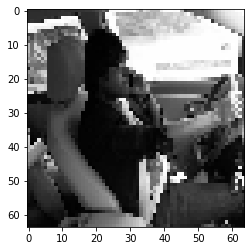

Y prediction: [[8.9999750e-09 1.4008807e-03 7.8357667e-09 7.6271459e-03 3.2882705e-02
  3.0783007e-10 6.1024094e-01 3.0832154e-01 1.3883793e-04 3.9387923e-02]]
Predicted: Drinking
1/1 [==============================] - 0s 103ms/step
Y prediction: [[1.2270710e-09 5.4071698e-04 4.8870179e-09 1.0530458e-01 4.7606727e-01
  2.6653463e-08 6.5869018e-02 3.4791285e-01 2.1578019e-04 4.0898831e-03]]
Predicted: Talking on the phone - left


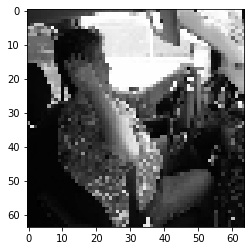

Y prediction: [[1.2270710e-09 5.4071698e-04 4.8870179e-09 1.0530458e-01 4.7606727e-01
  2.6653463e-08 6.5869018e-02 3.4791285e-01 2.1578019e-04 4.0898831e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 159ms/step
Y prediction: [[2.7380562e-10 3.0752431e-04 4.7216901e-09 1.1232907e-02 1.9109221e-01
  4.2773745e-09 5.8062036e-02 7.3652279e-01 3.4176017e-05 2.7483290e-03]]
Predicted: Reaching behind


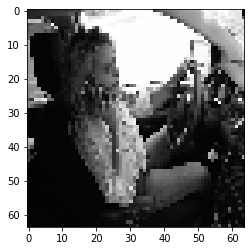

Y prediction: [[2.7380562e-10 3.0752431e-04 4.7216901e-09 1.1232907e-02 1.9109221e-01
  4.2773745e-09 5.8062036e-02 7.3652279e-01 3.4176017e-05 2.7483290e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 87ms/step
Y prediction: [[3.1281676e-08 1.3740803e-03 5.7179625e-07 4.8686609e-02 2.1827577e-01
  1.7481869e-06 4.0009551e-02 6.8764198e-01 1.0758730e-03 2.9338019e-03]]
Predicted: Reaching behind


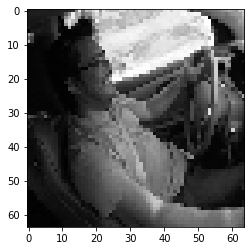

Y prediction: [[3.1281676e-08 1.3740803e-03 5.7179625e-07 4.8686609e-02 2.1827577e-01
  1.7481869e-06 4.0009551e-02 6.8764198e-01 1.0758730e-03 2.9338019e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 109ms/step
Y prediction: [[6.7923556e-10 2.5218344e-04 1.8019540e-08 3.5962679e-03 3.6752980e-02
  5.2913780e-09 2.4778917e-02 9.3115443e-01 1.5125604e-04 3.3139805e-03]]
Predicted: Reaching behind


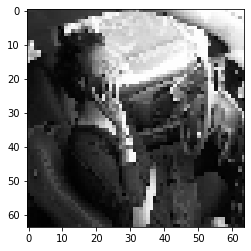

Y prediction: [[6.7923556e-10 2.5218344e-04 1.8019540e-08 3.5962679e-03 3.6752980e-02
  5.2913780e-09 2.4778917e-02 9.3115443e-01 1.5125604e-04 3.3139805e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 96ms/step
Y prediction: [[2.5325657e-11 5.3335014e-05 8.1482332e-10 2.1784760e-02 2.1814667e-01
  1.6212262e-10 7.7850348e-03 7.5206399e-01 1.4333987e-06 1.6476713e-04]]
Predicted: Reaching behind


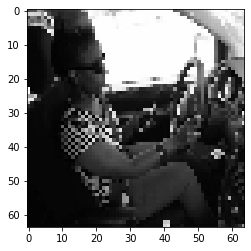

Y prediction: [[2.5325657e-11 5.3335014e-05 8.1482332e-10 2.1784760e-02 2.1814667e-01
  1.6212262e-10 7.7850348e-03 7.5206399e-01 1.4333987e-06 1.6476713e-04]]
Predicted: Reaching behind
1/1 [==============================] - 0s 41ms/step
Y prediction: [[1.2344552e-09 1.2025730e-04 8.1537781e-09 3.6825940e-03 4.9863029e-01
  3.0655212e-09 2.2031033e-01 2.7422062e-01 1.2295923e-05 3.0235567e-03]]
Predicted: Talking on the phone - left


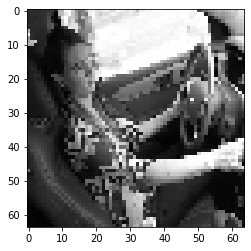

Y prediction: [[1.2344552e-09 1.2025730e-04 8.1537781e-09 3.6825940e-03 4.9863029e-01
  3.0655212e-09 2.2031033e-01 2.7422062e-01 1.2295923e-05 3.0235567e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 115ms/step
Y prediction: [[1.4070218e-09 6.9619469e-05 1.6503405e-08 2.5827566e-02 3.9664216e-02
  1.4044190e-08 1.4338779e-02 9.1225874e-01 8.9472742e-05 7.7514965e-03]]
Predicted: Reaching behind


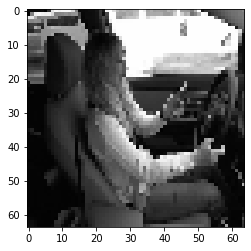

Y prediction: [[1.4070218e-09 6.9619469e-05 1.6503405e-08 2.5827566e-02 3.9664216e-02
  1.4044190e-08 1.4338779e-02 9.1225874e-01 8.9472742e-05 7.7514965e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 49ms/step
Y prediction: [[1.4790696e-09 8.1642828e-04 3.9175023e-09 2.1315686e-02 3.5556039e-01
  2.8580471e-10 9.7664580e-02 5.1515043e-01 7.0293543e-05 9.4220554e-03]]
Predicted: Reaching behind


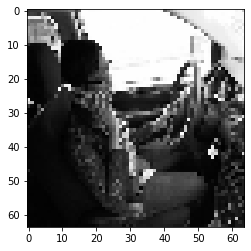

Y prediction: [[1.4790696e-09 8.1642828e-04 3.9175023e-09 2.1315686e-02 3.5556039e-01
  2.8580471e-10 9.7664580e-02 5.1515043e-01 7.0293543e-05 9.4220554e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 29ms/step
Y prediction: [[1.9746305e-11 2.4884060e-04 7.6523099e-10 4.2402625e-02 5.6673360e-01
  1.0667838e-09 7.2953649e-02 3.1759086e-01 2.5238903e-06 6.7907764e-05]]
Predicted: Talking on the phone - left


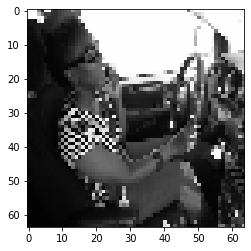

Y prediction: [[1.9746305e-11 2.4884060e-04 7.6523099e-10 4.2402625e-02 5.6673360e-01
  1.0667838e-09 7.2953649e-02 3.1759086e-01 2.5238903e-06 6.7907764e-05]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 119ms/step
Y prediction: [[8.3877522e-10 2.5749737e-03 3.9625490e-09 3.5657138e-02 1.8062862e-02
  3.5511662e-09 1.8959869e-02 9.1165036e-01 4.6293999e-04 1.2631929e-02]]
Predicted: Reaching behind


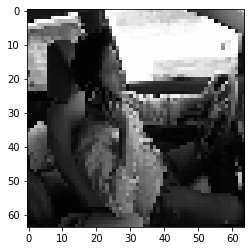

Y prediction: [[8.3877522e-10 2.5749737e-03 3.9625490e-09 3.5657138e-02 1.8062862e-02
  3.5511662e-09 1.8959869e-02 9.1165036e-01 4.6293999e-04 1.2631929e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 150ms/step
Y prediction: [[1.0238378e-11 2.8339768e-04 3.5280223e-10 1.7813472e-02 5.2453339e-01
  6.1677552e-10 9.9171679e-03 4.4737113e-01 2.1027183e-06 7.9290890e-05]]
Predicted: Talking on the phone - left


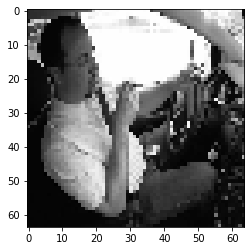

Y prediction: [[1.0238378e-11 2.8339768e-04 3.5280223e-10 1.7813472e-02 5.2453339e-01
  6.1677552e-10 9.9171679e-03 4.4737113e-01 2.1027183e-06 7.9290890e-05]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 40ms/step
Y prediction: [[7.5575025e-11 1.6511029e-02 2.4822968e-09 4.0145088e-02 2.6640132e-01
  6.0110095e-10 2.2102658e-01 4.5505685e-01 6.7175533e-05 7.9196336e-04]]
Predicted: Reaching behind


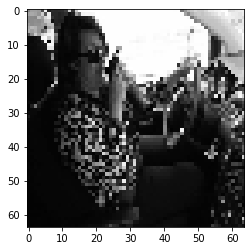

Y prediction: [[7.5575025e-11 1.6511029e-02 2.4822968e-09 4.0145088e-02 2.6640132e-01
  6.0110095e-10 2.2102658e-01 4.5505685e-01 6.7175533e-05 7.9196336e-04]]
Predicted: Reaching behind
1/1 [==============================] - 0s 84ms/step
Y prediction: [[1.1225989e-08 8.9818006e-03 3.3063134e-07 1.3664800e-01 2.9606193e-01
  8.4177664e-08 1.4167975e-01 3.9615312e-01 1.7064821e-03 1.8768532e-02]]
Predicted: Reaching behind


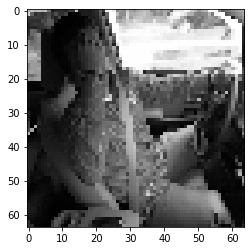

Y prediction: [[1.1225989e-08 8.9818006e-03 3.3063134e-07 1.3664800e-01 2.9606193e-01
  8.4177664e-08 1.4167975e-01 3.9615312e-01 1.7064821e-03 1.8768532e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 86ms/step
Y prediction: [[1.6035169e-07 4.1608688e-05 3.3448075e-08 7.4972220e-02 9.0043187e-01
  1.9566724e-09 1.8221758e-02 3.8905852e-03 2.4619392e-05 2.4170962e-03]]
Predicted: Talking on the phone - left


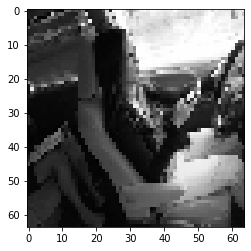

Y prediction: [[1.6035169e-07 4.1608688e-05 3.3448075e-08 7.4972220e-02 9.0043187e-01
  1.9566724e-09 1.8221758e-02 3.8905852e-03 2.4619392e-05 2.4170962e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 38ms/step
Y prediction: [[4.9231243e-08 2.3666846e-04 2.6741674e-07 1.1293600e-02 1.2809560e-01
  1.3958212e-09 1.0311606e-01 7.4357855e-01 6.7243374e-05 1.3611858e-02]]
Predicted: Reaching behind


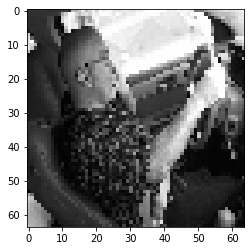

Y prediction: [[4.9231243e-08 2.3666846e-04 2.6741674e-07 1.1293600e-02 1.2809560e-01
  1.3958212e-09 1.0311606e-01 7.4357855e-01 6.7243374e-05 1.3611858e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 132ms/step
Y prediction: [[2.8250486e-06 4.3120989e-04 5.5510714e-08 6.6404544e-02 8.5823303e-01
  2.5068920e-09 6.1458487e-02 7.8917947e-03 4.2259278e-05 5.5358261e-03]]
Predicted: Talking on the phone - left


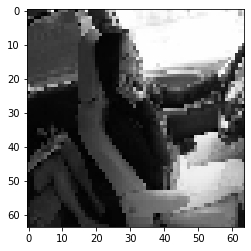

Y prediction: [[2.8250486e-06 4.3120989e-04 5.5510714e-08 6.6404544e-02 8.5823303e-01
  2.5068920e-09 6.1458487e-02 7.8917947e-03 4.2259278e-05 5.5358261e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 25ms/step
Y prediction: [[8.4921830e-09 9.0690991e-03 1.1972723e-08 4.3449908e-02 3.3914566e-01
  6.1612865e-10 2.1892610e-01 3.8303787e-01 1.5389982e-04 6.2174811e-03]]
Predicted: Reaching behind


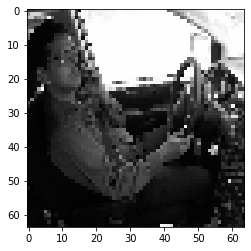

Y prediction: [[8.4921830e-09 9.0690991e-03 1.1972723e-08 4.3449908e-02 3.3914566e-01
  6.1612865e-10 2.1892610e-01 3.8303787e-01 1.5389982e-04 6.2174811e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 155ms/step
Y prediction: [[9.1626973e-10 1.4979181e-02 1.1167540e-08 3.3973571e-02 1.9673854e-01
  2.0786713e-10 4.7117996e-01 2.7996686e-01 7.7178745e-05 3.0847602e-03]]
Predicted: Drinking


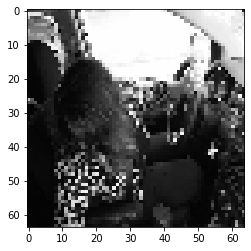

Y prediction: [[9.1626973e-10 1.4979181e-02 1.1167540e-08 3.3973571e-02 1.9673854e-01
  2.0786713e-10 4.7117996e-01 2.7996686e-01 7.7178745e-05 3.0847602e-03]]
Predicted: Drinking
1/1 [==============================] - 0s 29ms/step
Y prediction: [[6.2601213e-10 1.7761920e-03 5.4435292e-09 6.6312328e-02 8.9657232e-02
  1.7670528e-09 1.7348325e-02 7.9275751e-01 9.1650529e-04 3.1231882e-02]]
Predicted: Reaching behind


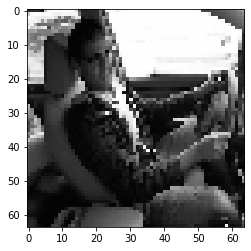

Y prediction: [[6.2601213e-10 1.7761920e-03 5.4435292e-09 6.6312328e-02 8.9657232e-02
  1.7670528e-09 1.7348325e-02 7.9275751e-01 9.1650529e-04 3.1231882e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 201ms/step
Y prediction: [[3.8774201e-07 2.2236486e-04 1.9690233e-07 2.3295650e-02 3.6387742e-01
  8.4086601e-08 1.7558196e-01 4.3236288e-01 3.1673515e-04 4.3422980e-03]]
Predicted: Reaching behind


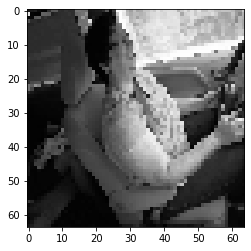

Y prediction: [[3.8774201e-07 2.2236486e-04 1.9690233e-07 2.3295650e-02 3.6387742e-01
  8.4086601e-08 1.7558196e-01 4.3236288e-01 3.1673515e-04 4.3422980e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 91ms/step
Y prediction: [[3.15721920e-08 1.92030438e-03 1.18000294e-08 1.19543653e-02
  1.16195545e-01 9.39628597e-10 5.04054606e-01 3.55581075e-01
  2.85855436e-04 1.00081554e-02]]
Predicted: Drinking


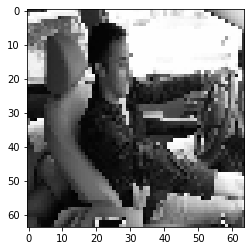

Y prediction: [[3.15721920e-08 1.92030438e-03 1.18000294e-08 1.19543653e-02
  1.16195545e-01 9.39628597e-10 5.04054606e-01 3.55581075e-01
  2.85855436e-04 1.00081554e-02]]
Predicted: Drinking
1/1 [==============================] - 0s 97ms/step
Y prediction: [[4.4987694e-09 9.8344008e-04 1.1679584e-08 6.4273614e-01 8.7930657e-02
  8.4443030e-09 2.2682413e-02 2.4206820e-01 1.3991531e-04 3.4591879e-03]]
Predicted: Texting - left


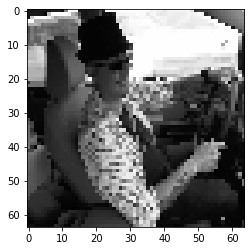

Y prediction: [[4.4987694e-09 9.8344008e-04 1.1679584e-08 6.4273614e-01 8.7930657e-02
  8.4443030e-09 2.2682413e-02 2.4206820e-01 1.3991531e-04 3.4591879e-03]]
Predicted: Texting - left
1/1 [==============================] - 0s 76ms/step
Y prediction: [[5.7944975e-11 7.9828991e-05 1.8675761e-08 6.3218321e-03 3.3039007e-02
  8.4820018e-09 1.4037628e-02 9.4551796e-01 3.1395870e-05 9.7239658e-04]]
Predicted: Reaching behind


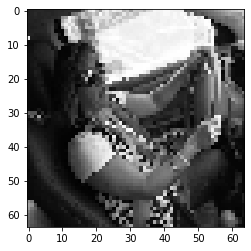

Y prediction: [[5.7944975e-11 7.9828991e-05 1.8675761e-08 6.3218321e-03 3.3039007e-02
  8.4820018e-09 1.4037628e-02 9.4551796e-01 3.1395870e-05 9.7239658e-04]]
Predicted: Reaching behind
1/1 [==============================] - 0s 65ms/step
Y prediction: [[1.8039514e-10 1.1960777e-03 9.5584012e-09 6.4410992e-02 2.9291549e-01
  7.2478525e-07 1.6720201e-01 4.7332332e-01 3.6910066e-04 5.8227754e-04]]
Predicted: Reaching behind


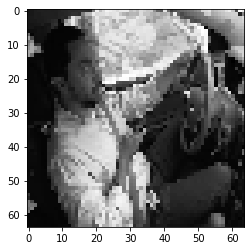

Y prediction: [[1.8039514e-10 1.1960777e-03 9.5584012e-09 6.4410992e-02 2.9291549e-01
  7.2478525e-07 1.6720201e-01 4.7332332e-01 3.6910066e-04 5.8227754e-04]]
Predicted: Reaching behind
1/1 [==============================] - 0s 155ms/step
Y prediction: [[8.1177284e-08 1.0769049e-02 7.1228314e-08 1.5135890e-01 8.4369145e-02
  5.1557802e-08 2.4287899e-01 4.5874733e-01 7.0752419e-04 5.1168811e-02]]
Predicted: Reaching behind


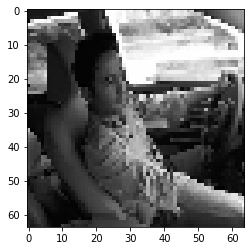

Y prediction: [[8.1177284e-08 1.0769049e-02 7.1228314e-08 1.5135890e-01 8.4369145e-02
  5.1557802e-08 2.4287899e-01 4.5874733e-01 7.0752419e-04 5.1168811e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 19ms/step
Y prediction: [[6.1329848e-09 2.4293852e-03 6.7486519e-09 1.0951695e-02 2.0495164e-01
  1.9711215e-10 6.5259159e-01 1.1971672e-01 2.7709968e-05 9.3312776e-03]]
Predicted: Drinking


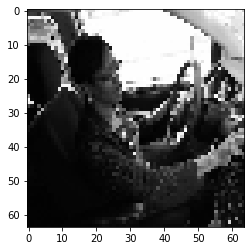

Y prediction: [[6.1329848e-09 2.4293852e-03 6.7486519e-09 1.0951695e-02 2.0495164e-01
  1.9711215e-10 6.5259159e-01 1.1971672e-01 2.7709968e-05 9.3312776e-03]]
Predicted: Drinking
1/1 [==============================] - 0s 129ms/step
Y prediction: [[5.6338068e-09 1.0117220e-03 2.4588314e-08 3.1311801e-01 4.8358852e-01
  4.7422950e-09 4.5092236e-02 1.4956777e-01 1.6943310e-04 7.4522668e-03]]
Predicted: Talking on the phone - left


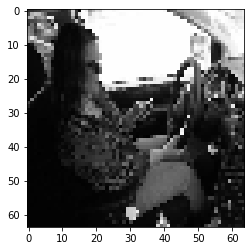

Y prediction: [[5.6338068e-09 1.0117220e-03 2.4588314e-08 3.1311801e-01 4.8358852e-01
  4.7422950e-09 4.5092236e-02 1.4956777e-01 1.6943310e-04 7.4522668e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 124ms/step
Y prediction: [[1.58164726e-09 2.48807669e-03 8.19769141e-09 1.03494674e-01
  5.01508892e-01 1.89897231e-09 2.24126149e-02 3.63972753e-01
  1.31195426e-04 5.99175785e-03]]
Predicted: Talking on the phone - left


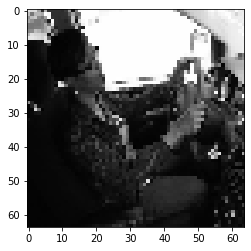

Y prediction: [[1.58164726e-09 2.48807669e-03 8.19769141e-09 1.03494674e-01
  5.01508892e-01 1.89897231e-09 2.24126149e-02 3.63972753e-01
  1.31195426e-04 5.99175785e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 97ms/step
Y prediction: [[6.7266831e-11 1.3835959e-03 4.1681809e-09 1.7632705e-03 5.3557307e-02
  1.1402348e-09 4.1521341e-01 5.2638125e-01 5.4585482e-05 1.6466004e-03]]
Predicted: Reaching behind


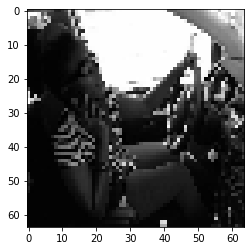

Y prediction: [[6.7266831e-11 1.3835959e-03 4.1681809e-09 1.7632705e-03 5.3557307e-02
  1.1402348e-09 4.1521341e-01 5.2638125e-01 5.4585482e-05 1.6466004e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 166ms/step
Y prediction: [[5.91659794e-12 6.85958366e-05 6.50776447e-11 9.85225779e-04
  1.03608884e-01 1.15893527e-11 2.28106324e-02 8.72465551e-01
  5.72530496e-07 6.05458299e-05]]
Predicted: Reaching behind


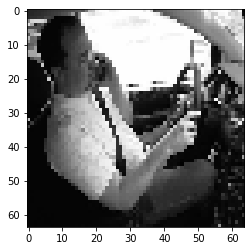

Y prediction: [[5.91659794e-12 6.85958366e-05 6.50776447e-11 9.85225779e-04
  1.03608884e-01 1.15893527e-11 2.28106324e-02 8.72465551e-01
  5.72530496e-07 6.05458299e-05]]
Predicted: Reaching behind
1/1 [==============================] - 0s 73ms/step
Y prediction: [[1.7872822e-09 6.2297180e-04 6.6767809e-09 1.7543173e-01 5.9224021e-01
  1.5594225e-08 4.4827268e-02 1.8614990e-01 1.4878795e-04 5.7912152e-04]]
Predicted: Talking on the phone - left


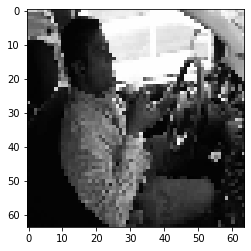

Y prediction: [[1.7872822e-09 6.2297180e-04 6.6767809e-09 1.7543173e-01 5.9224021e-01
  1.5594225e-08 4.4827268e-02 1.8614990e-01 1.4878795e-04 5.7912152e-04]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 90ms/step
Y prediction: [[1.1300729e-06 4.0782828e-04 3.4237153e-06 4.7523953e-02 4.4976199e-01
  7.3902889e-08 6.8284549e-02 3.8625500e-01 4.8634270e-04 4.7275782e-02]]
Predicted: Talking on the phone - left


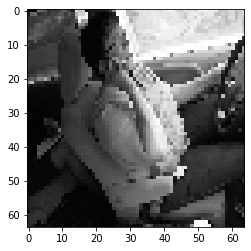

Y prediction: [[1.1300729e-06 4.0782828e-04 3.4237153e-06 4.7523953e-02 4.4976199e-01
  7.3902889e-08 6.8284549e-02 3.8625500e-01 4.8634270e-04 4.7275782e-02]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 33ms/step
Y prediction: [[1.3392266e-11 2.3935433e-04 1.1636651e-10 2.4981857e-03 2.3353438e-01
  7.5439301e-11 9.1057740e-02 6.7254531e-01 1.7799791e-06 1.2323972e-04]]
Predicted: Reaching behind


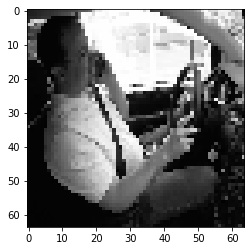

Y prediction: [[1.3392266e-11 2.3935433e-04 1.1636651e-10 2.4981857e-03 2.3353438e-01
  7.5439301e-11 9.1057740e-02 6.7254531e-01 1.7799791e-06 1.2323972e-04]]
Predicted: Reaching behind
1/1 [==============================] - 0s 29ms/step
Y prediction: [[5.2210909e-12 1.0505492e-04 5.3247812e-11 2.7572589e-02 4.2976853e-01
  7.2825704e-11 5.6431349e-02 4.8593935e-01 5.1757377e-07 1.8258604e-04]]
Predicted: Reaching behind


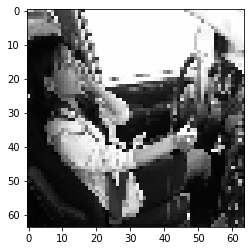

Y prediction: [[5.2210909e-12 1.0505492e-04 5.3247812e-11 2.7572589e-02 4.2976853e-01
  7.2825704e-11 5.6431349e-02 4.8593935e-01 5.1757377e-07 1.8258604e-04]]
Predicted: Reaching behind
1/1 [==============================] - 0s 130ms/step
Y prediction: [[1.1191612e-09 7.1947824e-04 9.0261407e-09 2.8349410e-03 4.1465133e-02
  2.5191346e-10 1.7228504e-01 7.7173626e-01 3.3537064e-05 1.0925680e-02]]
Predicted: Reaching behind


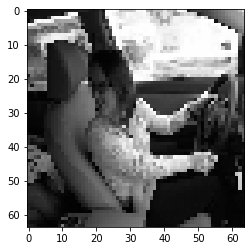

Y prediction: [[1.1191612e-09 7.1947824e-04 9.0261407e-09 2.8349410e-03 4.1465133e-02
  2.5191346e-10 1.7228504e-01 7.7173626e-01 3.3537064e-05 1.0925680e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 129ms/step
Y prediction: [[2.1633308e-09 3.8644319e-04 3.0500015e-08 1.8886348e-02 7.0294403e-02
  2.2910131e-08 1.1613674e-01 7.7118051e-01 3.1879026e-04 2.2796649e-02]]
Predicted: Reaching behind


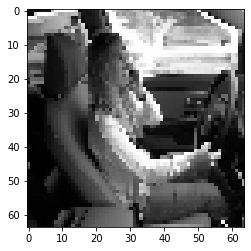

Y prediction: [[2.1633308e-09 3.8644319e-04 3.0500015e-08 1.8886348e-02 7.0294403e-02
  2.2910131e-08 1.1613674e-01 7.7118051e-01 3.1879026e-04 2.2796649e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 230ms/step
Y prediction: [[1.3025867e-08 8.9284906e-04 1.3644378e-08 2.2279620e-02 1.4523073e-01
  3.9090736e-10 1.2471445e-01 6.8584579e-01 4.5715155e-05 2.0990763e-02]]
Predicted: Reaching behind


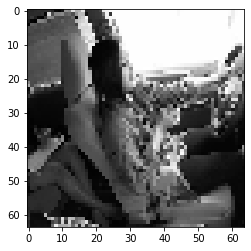

Y prediction: [[1.3025867e-08 8.9284906e-04 1.3644378e-08 2.2279620e-02 1.4523073e-01
  3.9090736e-10 1.2471445e-01 6.8584579e-01 4.5715155e-05 2.0990763e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 158ms/step
Y prediction: [[1.8633990e-09 2.4387436e-03 6.0924989e-09 6.0622953e-02 9.5205441e-02
  2.5086206e-09 1.6339749e-01 6.2641382e-01 1.8056095e-04 5.1741056e-02]]
Predicted: Reaching behind


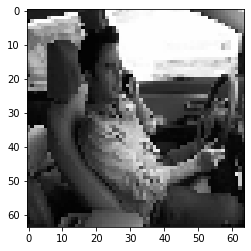

Y prediction: [[1.8633990e-09 2.4387436e-03 6.0924989e-09 6.0622953e-02 9.5205441e-02
  2.5086206e-09 1.6339749e-01 6.2641382e-01 1.8056095e-04 5.1741056e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 97ms/step
Y prediction: [[3.4111829e-09 9.8661205e-04 1.5669668e-08 3.4778181e-02 1.7805621e-01
  1.4242246e-08 2.9311676e-02 7.5470829e-01 1.5069662e-04 2.0083515e-03]]
Predicted: Reaching behind


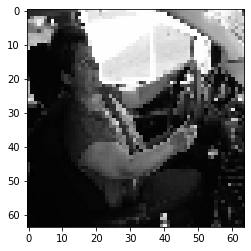

Y prediction: [[3.4111829e-09 9.8661205e-04 1.5669668e-08 3.4778181e-02 1.7805621e-01
  1.4242246e-08 2.9311676e-02 7.5470829e-01 1.5069662e-04 2.0083515e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 89ms/step
Y prediction: [[1.4500802e-07 9.8739081e-05 3.4669435e-07 8.3978139e-03 4.0459982e-01
  3.8359134e-09 7.8616478e-02 4.8193970e-01 9.0289177e-05 2.6256563e-02]]
Predicted: Reaching behind


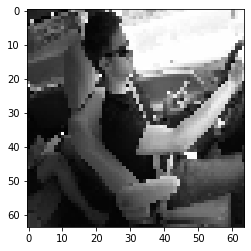

Y prediction: [[1.4500802e-07 9.8739081e-05 3.4669435e-07 8.3978139e-03 4.0459982e-01
  3.8359134e-09 7.8616478e-02 4.8193970e-01 9.0289177e-05 2.6256563e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 105ms/step
Y prediction: [[8.4249629e-09 1.9764034e-03 1.1451739e-07 1.0498091e-02 4.9758449e-02
  4.4884740e-09 3.2038275e-02 8.9711350e-01 2.4082456e-04 8.3743036e-03]]
Predicted: Reaching behind


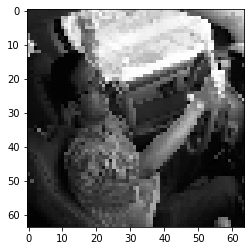

Y prediction: [[8.4249629e-09 1.9764034e-03 1.1451739e-07 1.0498091e-02 4.9758449e-02
  4.4884740e-09 3.2038275e-02 8.9711350e-01 2.4082456e-04 8.3743036e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 69ms/step
Y prediction: [[1.0932111e-09 5.3710822e-04 4.1521977e-09 6.5179944e-02 2.0557345e-01
  1.5144428e-08 1.1463895e-01 6.0811836e-01 1.6329139e-04 5.7889535e-03]]
Predicted: Reaching behind


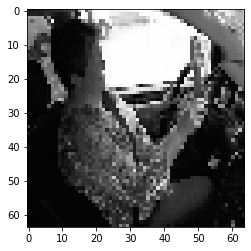

Y prediction: [[1.0932111e-09 5.3710822e-04 4.1521977e-09 6.5179944e-02 2.0557345e-01
  1.5144428e-08 1.1463895e-01 6.0811836e-01 1.6329139e-04 5.7889535e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 110ms/step
Y prediction: [[1.1544354e-07 6.5620611e-06 2.5863898e-08 2.1521221e-01 5.9283829e-01
  5.0601279e-09 1.5838878e-01 2.8881280e-02 1.1361248e-05 4.6614041e-03]]
Predicted: Talking on the phone - left


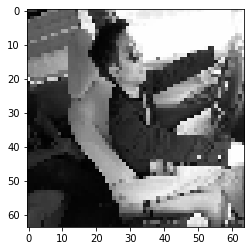

Y prediction: [[1.1544354e-07 6.5620611e-06 2.5863898e-08 2.1521221e-01 5.9283829e-01
  5.0601279e-09 1.5838878e-01 2.8881280e-02 1.1361248e-05 4.6614041e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 67ms/step
Y prediction: [[7.12645871e-08 1.83337519e-03 1.07867606e-07 5.11345565e-02
  5.67718983e-01 1.46324970e-08 2.36128330e-01 6.10108338e-02
  9.77319898e-04 8.11964050e-02]]
Predicted: Talking on the phone - left


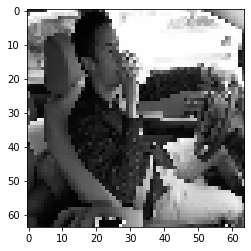

Y prediction: [[7.12645871e-08 1.83337519e-03 1.07867606e-07 5.11345565e-02
  5.67718983e-01 1.46324970e-08 2.36128330e-01 6.10108338e-02
  9.77319898e-04 8.11964050e-02]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 26ms/step
Y prediction: [[1.3287610e-09 1.9672946e-03 7.2010373e-08 2.7331056e-02 1.5575618e-01
  3.5059728e-08 1.6255888e-01 6.4848918e-01 9.0635207e-05 3.8067033e-03]]
Predicted: Reaching behind


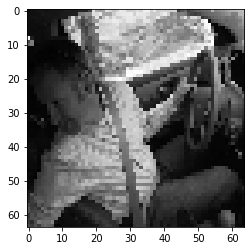

Y prediction: [[1.3287610e-09 1.9672946e-03 7.2010373e-08 2.7331056e-02 1.5575618e-01
  3.5059728e-08 1.6255888e-01 6.4848918e-01 9.0635207e-05 3.8067033e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 85ms/step
Y prediction: [[1.5576061e-08 3.0202833e-05 1.8834061e-08 4.1022869e-03 9.8844133e-02
  3.1658209e-09 2.6098646e-02 8.6651039e-01 3.6399237e-05 4.3778969e-03]]
Predicted: Reaching behind


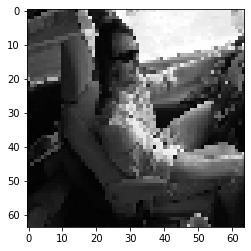

Y prediction: [[1.5576061e-08 3.0202833e-05 1.8834061e-08 4.1022869e-03 9.8844133e-02
  3.1658209e-09 2.6098646e-02 8.6651039e-01 3.6399237e-05 4.3778969e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 151ms/step
Y prediction: [[4.0357548e-09 6.3099497e-04 6.3212453e-09 9.3630634e-02 9.1864057e-02
  8.0125808e-09 1.9410852e-01 5.8195412e-01 1.3077699e-03 3.6503870e-02]]
Predicted: Reaching behind


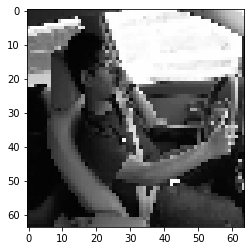

Y prediction: [[4.0357548e-09 6.3099497e-04 6.3212453e-09 9.3630634e-02 9.1864057e-02
  8.0125808e-09 1.9410852e-01 5.8195412e-01 1.3077699e-03 3.6503870e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 48ms/step
Y prediction: [[2.57732538e-08 4.16649709e-05 1.70828152e-08 1.02014676e-01
  5.43304920e-01 3.90436838e-09 1.80187717e-01 1.65742740e-01
  1.24374754e-04 8.58393312e-03]]
Predicted: Talking on the phone - left


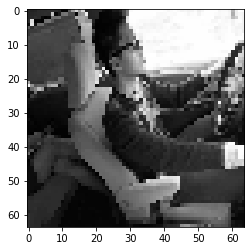

Y prediction: [[2.57732538e-08 4.16649709e-05 1.70828152e-08 1.02014676e-01
  5.43304920e-01 3.90436838e-09 1.80187717e-01 1.65742740e-01
  1.24374754e-04 8.58393312e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 104ms/step
Y prediction: [[1.6609209e-07 4.2260930e-05 1.1768442e-07 5.9724119e-03 7.7143982e-02
  7.3247740e-08 2.6365669e-02 8.8264513e-01 7.4242853e-05 7.7559184e-03]]
Predicted: Reaching behind


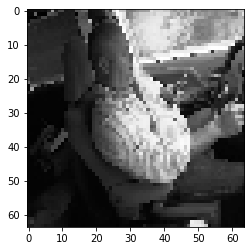

Y prediction: [[1.6609209e-07 4.2260930e-05 1.1768442e-07 5.9724119e-03 7.7143982e-02
  7.3247740e-08 2.6365669e-02 8.8264513e-01 7.4242853e-05 7.7559184e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 26ms/step
Y prediction: [[3.0520028e-10 3.9294374e-04 1.8250832e-08 7.7599455e-03 1.7293185e-01
  5.1781353e-09 2.9788217e-02 7.8756213e-01 7.1285525e-05 1.4935912e-03]]
Predicted: Reaching behind


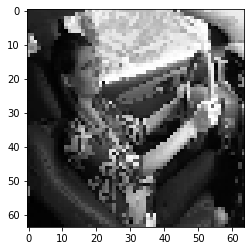

Y prediction: [[3.0520028e-10 3.9294374e-04 1.8250832e-08 7.7599455e-03 1.7293185e-01
  5.1781353e-09 2.9788217e-02 7.8756213e-01 7.1285525e-05 1.4935912e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 127ms/step
Y prediction: [[3.1461979e-11 4.2465990e-03 2.8627261e-09 3.0403450e-02 4.8416188e-01
  1.7954641e-09 3.0512711e-01 1.7499965e-01 1.0433842e-05 1.0509411e-03]]
Predicted: Talking on the phone - left


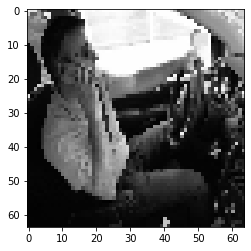

Y prediction: [[3.1461979e-11 4.2465990e-03 2.8627261e-09 3.0403450e-02 4.8416188e-01
  1.7954641e-09 3.0512711e-01 1.7499965e-01 1.0433842e-05 1.0509411e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 96ms/step
Y prediction: [[1.4019874e-09 1.4652313e-04 9.8214139e-09 7.7310383e-02 8.5811096e-01
  3.5493631e-08 2.9154839e-02 3.4838729e-02 4.4032797e-05 3.9444500e-04]]
Predicted: Talking on the phone - left


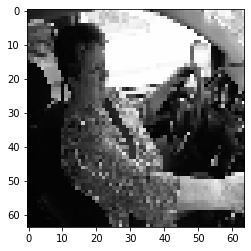

Y prediction: [[1.4019874e-09 1.4652313e-04 9.8214139e-09 7.7310383e-02 8.5811096e-01
  3.5493631e-08 2.9154839e-02 3.4838729e-02 4.4032797e-05 3.9444500e-04]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 97ms/step
Y prediction: [[1.29997091e-09 1.14918323e-04 1.23467725e-08 7.80171677e-02
  6.19455695e-01 4.65651375e-08 1.32167796e-02 2.84911156e-01
  3.96318326e-04 3.88793345e-03]]
Predicted: Talking on the phone - left


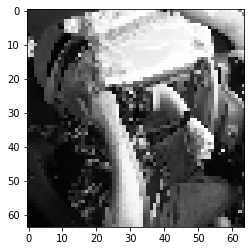

Y prediction: [[1.29997091e-09 1.14918323e-04 1.23467725e-08 7.80171677e-02
  6.19455695e-01 4.65651375e-08 1.32167796e-02 2.84911156e-01
  3.96318326e-04 3.88793345e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 218ms/step
Y prediction: [[1.8766142e-09 1.2745726e-04 1.3824208e-08 2.6786078e-02 1.5622208e-01
  7.6124422e-08 4.1423637e-02 7.7416009e-01 1.2828821e-04 1.1523340e-03]]
Predicted: Reaching behind


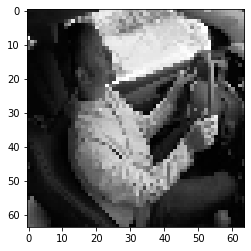

Y prediction: [[1.8766142e-09 1.2745726e-04 1.3824208e-08 2.6786078e-02 1.5622208e-01
  7.6124422e-08 4.1423637e-02 7.7416009e-01 1.2828821e-04 1.1523340e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 92ms/step
Y prediction: [[1.5877882e-11 3.0820269e-05 7.7727802e-10 6.8690362e-03 2.1068059e-02
  2.8403016e-10 2.9794371e-03 9.6830618e-01 2.7082599e-05 7.1936339e-04]]
Predicted: Reaching behind


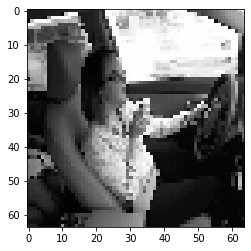

Y prediction: [[1.5877882e-11 3.0820269e-05 7.7727802e-10 6.8690362e-03 2.1068059e-02
  2.8403016e-10 2.9794371e-03 9.6830618e-01 2.7082599e-05 7.1936339e-04]]
Predicted: Reaching behind
1/1 [==============================] - 0s 52ms/step
Y prediction: [[1.8551103e-09 1.1734493e-03 2.0004741e-08 1.7391282e-01 3.4666562e-01
  6.1216198e-08 9.4745271e-02 3.7708151e-01 1.4584730e-04 6.2754415e-03]]
Predicted: Reaching behind


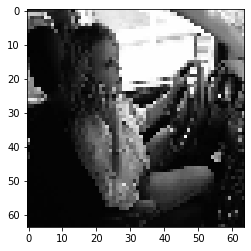

Y prediction: [[1.8551103e-09 1.1734493e-03 2.0004741e-08 1.7391282e-01 3.4666562e-01
  6.1216198e-08 9.4745271e-02 3.7708151e-01 1.4584730e-04 6.2754415e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 80ms/step
Y prediction: [[8.5615881e-10 4.9482443e-04 1.4615295e-08 7.0051104e-03 5.7761420e-02
  1.5534941e-09 5.1159509e-02 8.8009781e-01 4.8012858e-05 3.4333130e-03]]
Predicted: Reaching behind


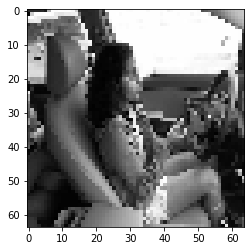

Y prediction: [[8.5615881e-10 4.9482443e-04 1.4615295e-08 7.0051104e-03 5.7761420e-02
  1.5534941e-09 5.1159509e-02 8.8009781e-01 4.8012858e-05 3.4333130e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 99ms/step
Y prediction: [[2.6321931e-10 6.5124899e-05 4.3812758e-08 7.0351129e-03 6.3748406e-03
  6.4478409e-09 1.4326434e-02 9.6980965e-01 1.7319162e-05 2.3714902e-03]]
Predicted: Reaching behind


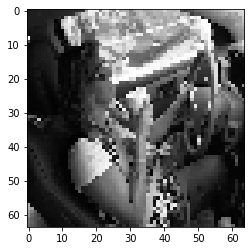

Y prediction: [[2.6321931e-10 6.5124899e-05 4.3812758e-08 7.0351129e-03 6.3748406e-03
  6.4478409e-09 1.4326434e-02 9.6980965e-01 1.7319162e-05 2.3714902e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 89ms/step
Y prediction: [[4.4199254e-12 1.2415689e-03 1.6006704e-10 1.4303945e-02 5.3399473e-02
  1.4719814e-11 2.3920712e-01 6.9056064e-01 1.7928012e-06 1.2855001e-03]]
Predicted: Reaching behind


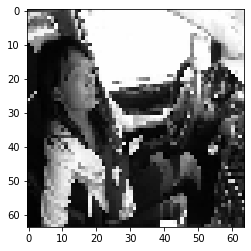

Y prediction: [[4.4199254e-12 1.2415689e-03 1.6006704e-10 1.4303945e-02 5.3399473e-02
  1.4719814e-11 2.3920712e-01 6.9056064e-01 1.7928012e-06 1.2855001e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 86ms/step
Y prediction: [[3.3803857e-10 2.9319394e-04 2.2000963e-09 1.2534286e-02 2.2183277e-01
  3.4728444e-12 9.8811373e-02 6.6168886e-01 3.5661424e-06 4.8360354e-03]]
Predicted: Reaching behind


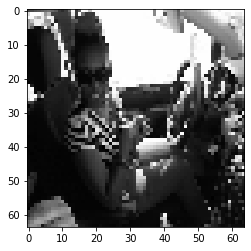

Y prediction: [[3.3803857e-10 2.9319394e-04 2.2000963e-09 1.2534286e-02 2.2183277e-01
  3.4728444e-12 9.8811373e-02 6.6168886e-01 3.5661424e-06 4.8360354e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 121ms/step
Y prediction: [[1.4682784e-07 2.5645626e-04 7.6222733e-07 7.7334337e-02 3.8889968e-01
  2.3919570e-08 3.8793102e-02 4.5899183e-01 5.9388322e-04 3.5129704e-02]]
Predicted: Reaching behind


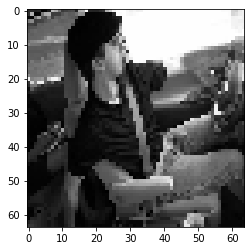

Y prediction: [[1.4682784e-07 2.5645626e-04 7.6222733e-07 7.7334337e-02 3.8889968e-01
  2.3919570e-08 3.8793102e-02 4.5899183e-01 5.9388322e-04 3.5129704e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 74ms/step
Y prediction: [[1.4601770e-07 1.2430630e-03 1.1141363e-07 1.2079958e-02 3.8113004e-01
  1.0972759e-08 2.2665469e-01 3.6600766e-01 1.3656856e-04 1.2747776e-02]]
Predicted: Talking on the phone - left


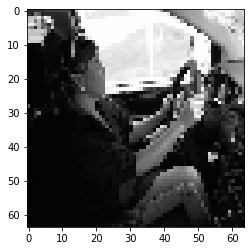

Y prediction: [[1.4601770e-07 1.2430630e-03 1.1141363e-07 1.2079958e-02 3.8113004e-01
  1.0972759e-08 2.2665469e-01 3.6600766e-01 1.3656856e-04 1.2747776e-02]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 215ms/step
Y prediction: [[2.2523929e-11 2.4064856e-04 3.2362790e-10 4.2938516e-03 5.5990076e-01
  6.4365853e-11 1.1355011e-01 3.2094708e-01 4.8901868e-05 1.0185781e-03]]
Predicted: Talking on the phone - left


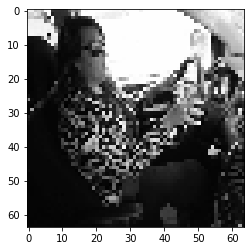

Y prediction: [[2.2523929e-11 2.4064856e-04 3.2362790e-10 4.2938516e-03 5.5990076e-01
  6.4365853e-11 1.1355011e-01 3.2094708e-01 4.8901868e-05 1.0185781e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 21ms/step
Y prediction: [[5.1944896e-11 1.8896695e-04 1.4932512e-10 7.4264128e-03 3.7562367e-02
  1.0604012e-11 1.1324068e-01 8.2755196e-01 9.2333197e-05 1.3937273e-02]]
Predicted: Reaching behind


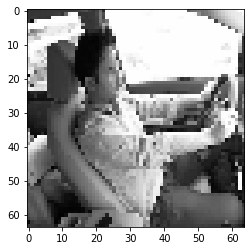

Y prediction: [[5.1944896e-11 1.8896695e-04 1.4932512e-10 7.4264128e-03 3.7562367e-02
  1.0604012e-11 1.1324068e-01 8.2755196e-01 9.2333197e-05 1.3937273e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 89ms/step
Y prediction: [[1.3697027e-09 2.3624371e-03 2.3668103e-09 4.1049611e-02 3.7977252e-02
  4.6695991e-11 3.3002558e-01 5.7795817e-01 3.9337167e-05 1.0587566e-02]]
Predicted: Reaching behind


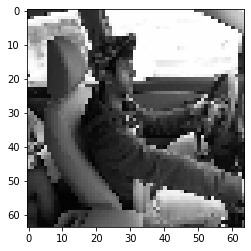

Y prediction: [[1.3697027e-09 2.3624371e-03 2.3668103e-09 4.1049611e-02 3.7977252e-02
  4.6695991e-11 3.3002558e-01 5.7795817e-01 3.9337167e-05 1.0587566e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 122ms/step
Y prediction: [[7.3142348e-10 1.5716496e-04 6.0035292e-09 8.4377609e-02 6.6866755e-01
  1.7731690e-08 9.0152510e-02 1.5481952e-01 2.0812341e-04 1.6176422e-03]]
Predicted: Talking on the phone - left


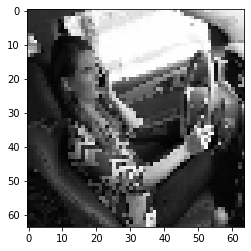

Y prediction: [[7.3142348e-10 1.5716496e-04 6.0035292e-09 8.4377609e-02 6.6866755e-01
  1.7731690e-08 9.0152510e-02 1.5481952e-01 2.0812341e-04 1.6176422e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 50ms/step
Y prediction: [[5.31819865e-07 9.00535524e-05 2.43823539e-08 1.58599287e-01
  6.98958158e-01 1.09030491e-08 1.18313976e-01 2.16485113e-02
  8.94971381e-05 2.29990412e-03]]
Predicted: Talking on the phone - left


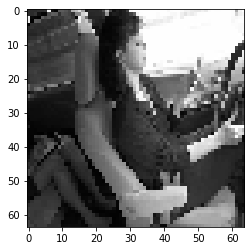

Y prediction: [[5.31819865e-07 9.00535524e-05 2.43823539e-08 1.58599287e-01
  6.98958158e-01 1.09030491e-08 1.18313976e-01 2.16485113e-02
  8.94971381e-05 2.29990412e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 87ms/step
Y prediction: [[2.1400189e-10 7.6553476e-04 3.3077829e-09 3.8016024e-03 1.6022488e-02
  5.5555111e-10 1.0083447e-02 9.6395063e-01 4.6880330e-05 5.3294473e-03]]
Predicted: Reaching behind


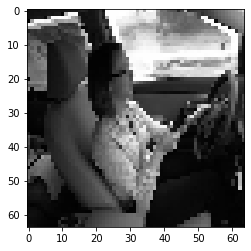

Y prediction: [[2.1400189e-10 7.6553476e-04 3.3077829e-09 3.8016024e-03 1.6022488e-02
  5.5555111e-10 1.0083447e-02 9.6395063e-01 4.6880330e-05 5.3294473e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 35ms/step
Y prediction: [[2.8917555e-08 2.3206936e-03 3.1781841e-08 2.1554124e-01 1.1255442e-01
  3.8102144e-08 2.0089982e-01 4.4929036e-01 1.2747665e-03 1.8118598e-02]]
Predicted: Reaching behind


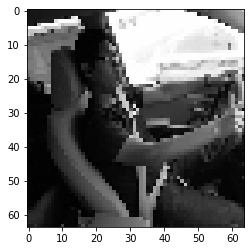

Y prediction: [[2.8917555e-08 2.3206936e-03 3.1781841e-08 2.1554124e-01 1.1255442e-01
  3.8102144e-08 2.0089982e-01 4.4929036e-01 1.2747665e-03 1.8118598e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 221ms/step
Y prediction: [[7.5449176e-09 8.3828677e-04 1.3023922e-08 6.4580923e-01 4.5325715e-02
  8.0821581e-09 1.8016590e-02 2.8213048e-01 5.5738288e-04 7.3223398e-03]]
Predicted: Texting - left


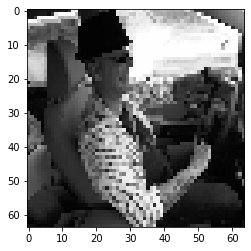

Y prediction: [[7.5449176e-09 8.3828677e-04 1.3023922e-08 6.4580923e-01 4.5325715e-02
  8.0821581e-09 1.8016590e-02 2.8213048e-01 5.5738288e-04 7.3223398e-03]]
Predicted: Texting - left
1/1 [==============================] - 0s 66ms/step
Y prediction: [[6.7901938e-12 5.5894670e-05 5.3632804e-10 6.1968965e-03 5.4899370e-03
  2.4351721e-10 1.0442763e-03 9.8694080e-01 5.5782066e-06 2.6661583e-04]]
Predicted: Reaching behind


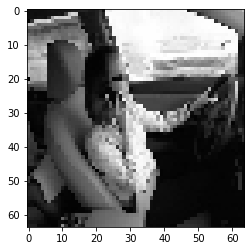

Y prediction: [[6.7901938e-12 5.5894670e-05 5.3632804e-10 6.1968965e-03 5.4899370e-03
  2.4351721e-10 1.0442763e-03 9.8694080e-01 5.5782066e-06 2.6661583e-04]]
Predicted: Reaching behind
1/1 [==============================] - 0s 46ms/step
Y prediction: [[3.6665050e-08 3.7620354e-03 1.6397679e-07 2.5598949e-01 2.0386715e-01
  6.3711996e-09 1.3645455e-01 3.3605263e-01 3.9288643e-04 6.3481137e-02]]
Predicted: Reaching behind


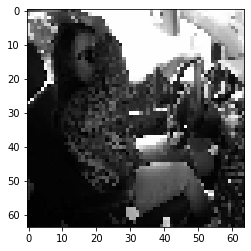

Y prediction: [[3.6665050e-08 3.7620354e-03 1.6397679e-07 2.5598949e-01 2.0386715e-01
  6.3711996e-09 1.3645455e-01 3.3605263e-01 3.9288643e-04 6.3481137e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 111ms/step
Y prediction: [[1.8421289e-10 1.3134906e-04 4.5144048e-09 3.7114576e-02 4.4377419e-01
  9.6401076e-10 3.5957452e-02 4.8155063e-01 9.2145301e-06 1.4626200e-03]]
Predicted: Reaching behind


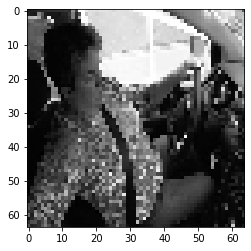

Y prediction: [[1.8421289e-10 1.3134906e-04 4.5144048e-09 3.7114576e-02 4.4377419e-01
  9.6401076e-10 3.5957452e-02 4.8155063e-01 9.2145301e-06 1.4626200e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 19ms/step
Y prediction: [[9.8694805e-08 1.0024329e-04 3.1534333e-07 9.2438862e-02 2.9715702e-01
  9.2115343e-10 2.7938995e-01 2.0732285e-01 2.3395442e-04 1.2335671e-01]]
Predicted: Talking on the phone - left


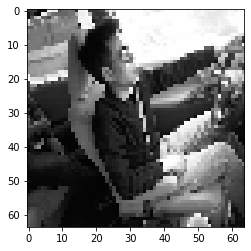

Y prediction: [[9.8694805e-08 1.0024329e-04 3.1534333e-07 9.2438862e-02 2.9715702e-01
  9.2115343e-10 2.7938995e-01 2.0732285e-01 2.3395442e-04 1.2335671e-01]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 138ms/step
Y prediction: [[6.4376302e-08 9.0261688e-05 1.5044489e-07 2.9861605e-02 6.2985605e-01
  6.3722666e-10 2.0824695e-01 7.2004534e-02 7.1699833e-05 5.9868712e-02]]
Predicted: Talking on the phone - left


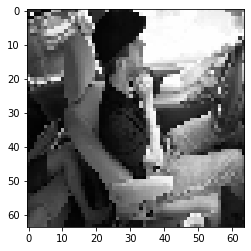

Y prediction: [[6.4376302e-08 9.0261688e-05 1.5044489e-07 2.9861605e-02 6.2985605e-01
  6.3722666e-10 2.0824695e-01 7.2004534e-02 7.1699833e-05 5.9868712e-02]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 140ms/step
Y prediction: [[1.8151113e-09 2.1316614e-03 1.4328488e-08 3.6593359e-02 3.3443233e-01
  4.2831829e-08 9.7663611e-02 5.2793479e-01 1.2284407e-04 1.1213832e-03]]
Predicted: Reaching behind


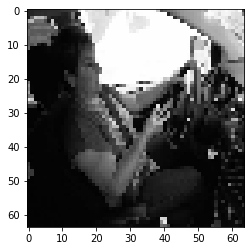

Y prediction: [[1.8151113e-09 2.1316614e-03 1.4328488e-08 3.6593359e-02 3.3443233e-01
  4.2831829e-08 9.7663611e-02 5.2793479e-01 1.2284407e-04 1.1213832e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 29ms/step
Y prediction: [[1.0382142e-09 6.9561834e-04 1.7515706e-08 5.7977345e-02 8.8153720e-02
  3.8868424e-09 1.8899599e-03 8.3694810e-01 1.7192461e-04 1.4163207e-02]]
Predicted: Reaching behind


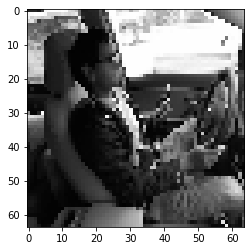

Y prediction: [[1.0382142e-09 6.9561834e-04 1.7515706e-08 5.7977345e-02 8.8153720e-02
  3.8868424e-09 1.8899599e-03 8.3694810e-01 1.7192461e-04 1.4163207e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 290ms/step
Y prediction: [[8.3431336e-13 4.5358270e-04 2.6217634e-11 2.8289465e-02 7.8532141e-01
  3.8859572e-11 1.5602431e-01 2.9643541e-02 3.5749855e-07 2.6726694e-04]]
Predicted: Talking on the phone - left


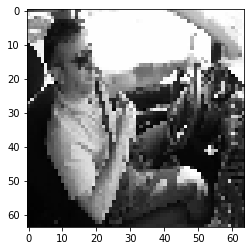

Y prediction: [[8.3431336e-13 4.5358270e-04 2.6217634e-11 2.8289465e-02 7.8532141e-01
  3.8859572e-11 1.5602431e-01 2.9643541e-02 3.5749855e-07 2.6726694e-04]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 278ms/step
Y prediction: [[1.0978681e-10 1.6836124e-04 4.8955389e-08 1.1181524e-01 8.9658700e-02
  4.3356273e-08 2.4644611e-02 7.7288681e-01 1.0254868e-04 7.2365184e-04]]
Predicted: Reaching behind


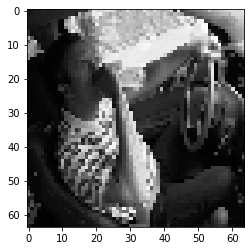

Y prediction: [[1.0978681e-10 1.6836124e-04 4.8955389e-08 1.1181524e-01 8.9658700e-02
  4.3356273e-08 2.4644611e-02 7.7288681e-01 1.0254868e-04 7.2365184e-04]]
Predicted: Reaching behind
1/1 [==============================] - 0s 178ms/step
Y prediction: [[4.0865583e-08 1.0141378e-04 1.7705203e-08 2.5401890e-02 8.8635987e-01
  8.3867642e-09 4.6728596e-02 3.4053896e-02 9.4754498e-05 7.2595319e-03]]
Predicted: Talking on the phone - left


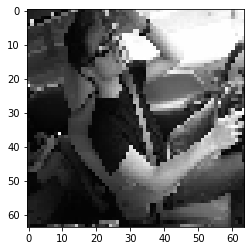

Y prediction: [[4.0865583e-08 1.0141378e-04 1.7705203e-08 2.5401890e-02 8.8635987e-01
  8.3867642e-09 4.6728596e-02 3.4053896e-02 9.4754498e-05 7.2595319e-03]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 77ms/step
Y prediction: [[7.9670454e-10 5.3147241e-03 4.1263608e-08 2.3856224e-01 2.0495445e-01
  4.0382014e-07 1.9099836e-01 3.3896509e-01 3.6452136e-03 1.7559536e-02]]
Predicted: Reaching behind


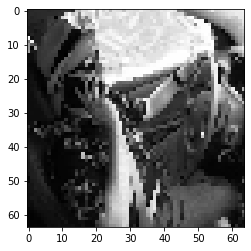

Y prediction: [[7.9670454e-10 5.3147241e-03 4.1263608e-08 2.3856224e-01 2.0495445e-01
  4.0382014e-07 1.9099836e-01 3.3896509e-01 3.6452136e-03 1.7559536e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 73ms/step
Y prediction: [[2.3962559e-09 1.2524015e-03 3.4506822e-08 4.1303013e-02 3.7678528e-01
  1.4988294e-09 1.8538992e-01 3.7752947e-01 8.0331498e-05 1.7659537e-02]]
Predicted: Reaching behind


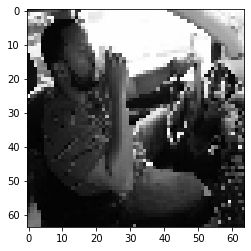

Y prediction: [[2.3962559e-09 1.2524015e-03 3.4506822e-08 4.1303013e-02 3.7678528e-01
  1.4988294e-09 1.8538992e-01 3.7752947e-01 8.0331498e-05 1.7659537e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 90ms/step
Y prediction: [[2.4123287e-07 1.2712354e-04 1.7991511e-07 3.2568447e-02 5.2906328e-01
  1.5378925e-08 9.7030744e-02 3.1998748e-01 7.9744277e-05 2.1142812e-02]]
Predicted: Talking on the phone - left


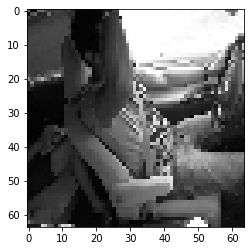

Y prediction: [[2.4123287e-07 1.2712354e-04 1.7991511e-07 3.2568447e-02 5.2906328e-01
  1.5378925e-08 9.7030744e-02 3.1998748e-01 7.9744277e-05 2.1142812e-02]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 191ms/step
Y prediction: [[6.6644250e-09 2.6601829e-04 2.9944772e-08 5.8048356e-02 5.5755848e-01
  1.0867657e-09 3.6813233e-02 3.3674416e-01 5.0588176e-05 1.0519122e-02]]
Predicted: Talking on the phone - left


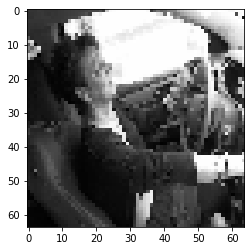

Y prediction: [[6.6644250e-09 2.6601829e-04 2.9944772e-08 5.8048356e-02 5.5755848e-01
  1.0867657e-09 3.6813233e-02 3.3674416e-01 5.0588176e-05 1.0519122e-02]]
Predicted: Talking on the phone - left
1/1 [==============================] - 0s 74ms/step
Y prediction: [[1.1795513e-09 2.4992489e-04 1.8370626e-08 1.9666994e-02 1.3824289e-01
  9.9247122e-10 3.2300733e-03 8.3481324e-01 5.9725618e-05 3.7371917e-03]]
Predicted: Reaching behind


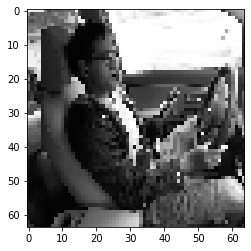

Y prediction: [[1.1795513e-09 2.4992489e-04 1.8370626e-08 1.9666994e-02 1.3824289e-01
  9.9247122e-10 3.2300733e-03 8.3481324e-01 5.9725618e-05 3.7371917e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 23ms/step
Y prediction: [[4.4478327e-10 2.4767907e-03 9.3318775e-08 1.2693145e-02 6.1341334e-02
  3.4769482e-07 7.9718314e-02 8.3923024e-01 4.9411139e-04 4.0456201e-03]]
Predicted: Reaching behind


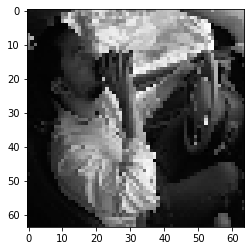

Y prediction: [[4.4478327e-10 2.4767907e-03 9.3318775e-08 1.2693145e-02 6.1341334e-02
  3.4769482e-07 7.9718314e-02 8.3923024e-01 4.9411139e-04 4.0456201e-03]]
Predicted: Reaching behind
1/1 [==============================] - 0s 72ms/step
Y prediction: [[2.0097560e-10 5.7348562e-04 9.6697041e-09 1.0947556e-01 1.3555169e-01
  4.1622688e-09 1.4824846e-02 7.2793490e-01 8.6130050e-05 1.1553444e-02]]
Predicted: Reaching behind


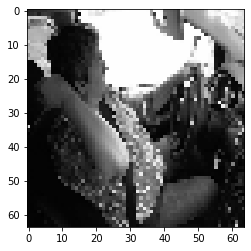

Y prediction: [[2.0097560e-10 5.7348562e-04 9.6697041e-09 1.0947556e-01 1.3555169e-01
  4.1622688e-09 1.4824846e-02 7.2793490e-01 8.6130050e-05 1.1553444e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 139ms/step
Y prediction: [[2.5330347e-09 1.2253403e-03 9.8565387e-09 3.2451358e-01 1.3072005e-01
  3.6997074e-09 5.5150971e-02 4.5651504e-01 7.1298779e-04 3.1162066e-02]]
Predicted: Reaching behind


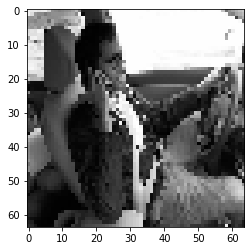

Y prediction: [[2.5330347e-09 1.2253403e-03 9.8565387e-09 3.2451358e-01 1.3072005e-01
  3.6997074e-09 5.5150971e-02 4.5651504e-01 7.1298779e-04 3.1162066e-02]]
Predicted: Reaching behind
1/1 [==============================] - 0s 67ms/step
Y prediction: [[2.0730818e-10 1.0972646e-04 6.7776860e-09 3.1186700e-02 2.2440101e-01
  1.4896866e-09 1.4314803e-01 5.9957832e-01 1.8146049e-05 1.5581078e-03]]
Predicted: Reaching behind


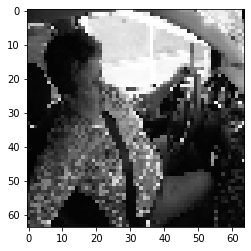

Y prediction: [[2.0730818e-10 1.0972646e-04 6.7776860e-09 3.1186700e-02 2.2440101e-01
  1.4896866e-09 1.4314803e-01 5.9957832e-01 1.8146049e-05 1.5581078e-03]]
Predicted: Reaching behind


In [47]:
for i in range(100):
    y_prediction = plot_test_class(model_v1, test_files, i)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    


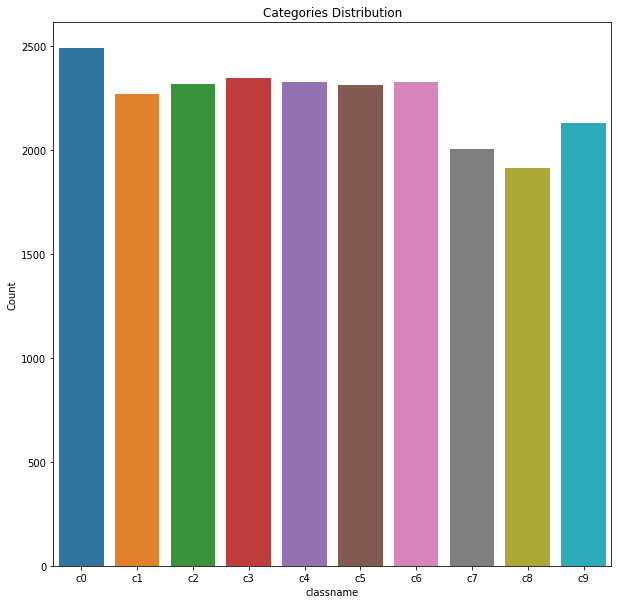

In [36]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()


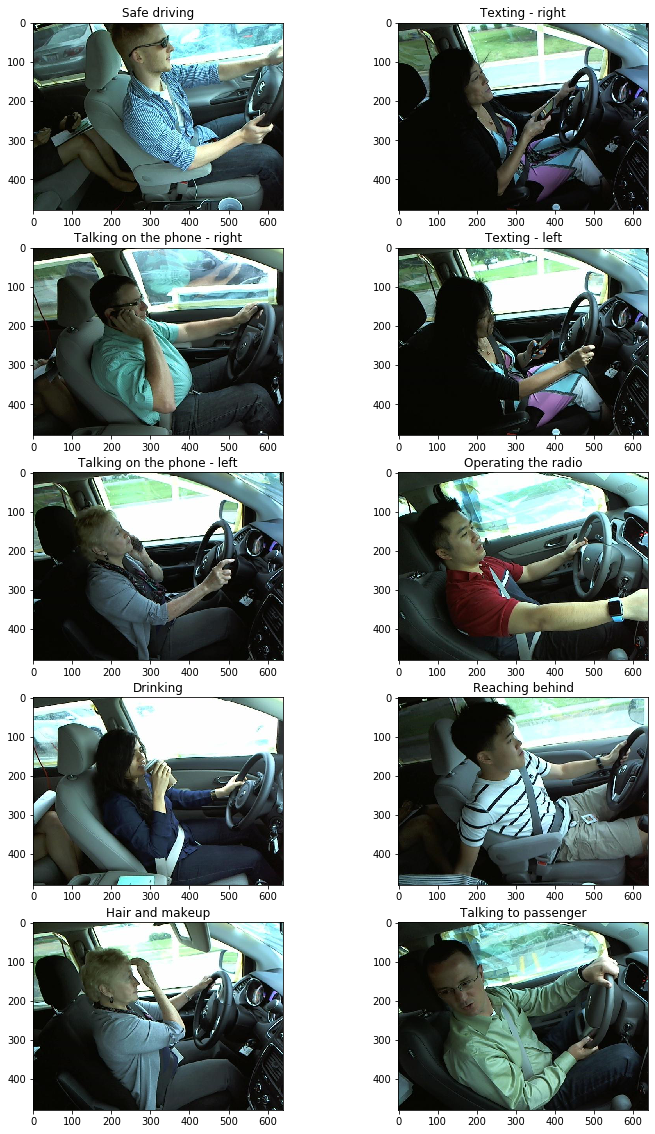

In [38]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = 'data/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])